In [7]:
import wave
import json
import librosa
import csv
import numpy as np
from pywt import wavedec
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [8]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [9]:
import wave
import json

def reset_csv():
  header = 'filename'
  for i in range(1, 41):
      header += f' mfcc{i}'
  for i in range(1, 13):
    header += f' chroma{i}'
  for i in range(1, 61):
    header += f' cqt{i}'
  header += ' label'
  header = header.split()
  file = open('testing.csv', 'w', newline='')
  with file:
      writer = csv.writer(file)
      writer.writerow(header)

In [10]:
def getModelArray(model_name):
  model_path = '../modelh5/'+model_name+'/best_model/'
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(model_path)):
    filenames.sort()
    filenames = filenames[10:] + filenames[:10]
    # cut each 10 array
    filenames = [filenames[i:i + 10] for i in range(0, len(filenames), 10)]
    return filenames[0], filenames[1], filenames[2], filenames[3], filenames[4], filenames[5], filenames[6], filenames[7], filenames[8], filenames[9]

def getPathModel(model_name):
  a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = getModelArray(model_name)
  # switch index 2 to 10
  hasil = []
  for i in [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10]:
    a = i[1]
    i.pop(1)
    i.append(a)
    for j in range(len(i)):
      i[j] = '../modelh5/'+model_name + '/best_model/' + i[j]
  return a1, a2, a3, a4, a5, a6, a7, a8, a9, a10

In [11]:
def testingVHD(array, db):
    index_db = 0
    accuracy_all = []
    precision_all = []
    sensitivity_all = []
    specificity_all = []
    f1_score_all = []

    for model_path in array:
        print("=======================================================")
        print("Processing "+ model_path)
        print("=======================================================")
        dataset_path = '../../data/testing_10/'
        reset_csv()

        for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
                # ensure we're processing a genre sub-folder level
                if dirpath is not dataset_path:
                    semantic_label = dirpath.split("/")[-1]
                    for f in filenames:
                        file_path = os.path.join(dirpath, f)
                        to_append = f'{file_path}'
                        # print(file_path)
                        y, sr = librosa.load(file_path, mono=True, duration=3, sr=8000)
                        coeffs = wavedec(y, f'db{db}', level=10)
                        cA,cD10,cD9,cD8,cD7,cD6,cD5,cD4,cD3,cD2, cD1 = coeffs
                        list_cd = [cD1, cD2, cD3, cD4, cD5, cD6, cD7, cD8, cD9, cD10]
                        mfcc = librosa.feature.mfcc(y=list_cd[index_db], sr=8000, n_mfcc=40, n_fft=2048, hop_length=512, n_mels=128)
                        rms = librosa.feature.chroma_stft(y=list_cd[index_db], sr=8000)
                        cqt = np.abs(librosa.cqt(y=list_cd[index_db], sr=sr, n_bins=60))
                        combined_features = np.concatenate((mfcc, rms, cqt), axis=0)
                        to_append = f'{file_path}'
                        for e in combined_features:
                            to_append += f' {np.mean(e.T, axis=0)}'
                        to_append += f' {semantic_label}'
                        file = open('testing.csv', 'a', newline='')
                        with file:
                            writer = csv.writer(file)
                            writer.writerow(to_append.split())
        index_db += 1
        data = pd.read_csv('./testing.csv')
        
        lb = LabelEncoder()
        X = np.expand_dims(data.drop(['label', 'filename'], axis=1), axis=2)
        y = np.expand_dims(data.iloc[:, -1], axis=1)


        model = tf.keras.models.load_model(model_path)
        pred = model.predict(X)
        hasil = []
        class_labels = ['AS', 'MR', 'MS', 'MVP', 'N']
        # class_labels = ['MVP', 'MS', 'N', 'MR', 'AS']
        for predic in pred:
            cek = np.argmax(predic)
            hasil.append(class_labels[cek])
        # y_p = np.argmax(pred, axis=1)

        cm = confusion_matrix(y, hasil)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AS', 'MR', 'MS', 'MVP', 'N'])
        disp.plot()
        plt.show()

        FP = cm.sum(axis=0) - np.diag(cm)  
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)

        # Overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)

        print("Accuracy :" , ACC, 'mean: ', np.mean(ACC))
        print("Precision :" , PPV, 'mean: ', np.mean(PPV))
        print("Sensitivity :" , TPR, 'mean: ', np.mean(TPR))
        print("Specificity :" , TNR, 'mean: ', np.mean(TNR))
        print("f1_score:", 2 * (PPV * TPR) / (PPV + TPR), 'mean: ', np.mean(2 * (PPV * TPR) / (PPV + TPR)))

        accuracy_all.append(np.mean(ACC))
        precision_all.append(np.mean(PPV))
        sensitivity_all.append(np.mean(TPR))
        specificity_all.append(np.mean(TNR))
        f1_score_all.append(np.mean(2 * (PPV * TPR) / (PPV + TPR)))

        print("\n\n")

    print("=======================================================")
    print("Accuracy All :" , accuracy_all)
    print("Precision All :" , precision_all)
    print("Sensitivity All :" , sensitivity_all)
    print("Specificity All :" , specificity_all)
    print("f1_score All :", f1_score_all)
    print("=======================================================")




In [12]:
a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = getPathModel("LSTM_NT")

Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb1L1.csv_2.h5
4/4 [==============================] - 0s 8ms/step


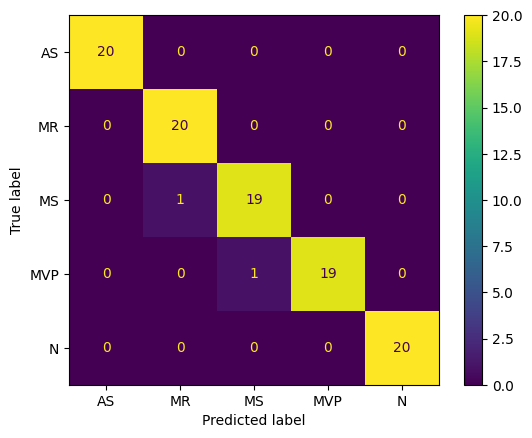

Accuracy : [1.   0.99 0.98 0.99 1.  ] mean:  0.992
Precision : [1.         0.95238095 0.95       1.         1.        ] mean:  0.9804761904761904
Sensitivity : [1.   1.   0.95 0.95 1.  ] mean:  0.9800000000000001
Specificity : [1.     0.9875 0.9875 1.     1.    ] mean:  0.9949999999999999
f1_score: [1.         0.97560976 0.95       0.97435897 1.        ] mean:  0.9799937460913071



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb1L2.csv_2.h5
4/4 [==============================] - 0s 9ms/step


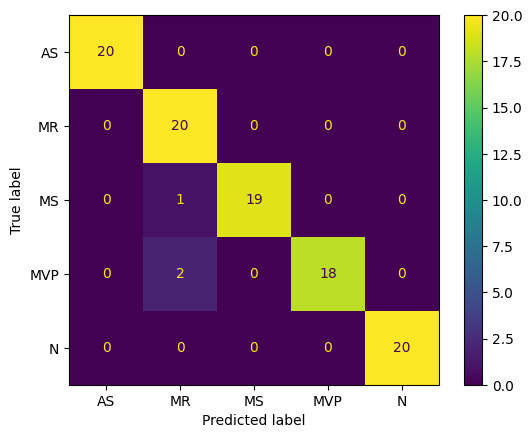

Accuracy : [1.   0.97 0.99 0.98 1.  ] mean:  0.9879999999999999
Precision : [1.         0.86956522 1.         1.         1.        ] mean:  0.9739130434782609
Sensitivity : [1.   1.   0.95 0.9  1.  ] mean:  0.97
Specificity : [1.     0.9625 1.     1.     1.    ] mean:  0.9925
f1_score: [1.         0.93023256 0.97435897 0.94736842 1.        ] mean:  0.9703919907102282



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb1L3.csv_2.h5
4/4 [==============================] - 0s 9ms/step


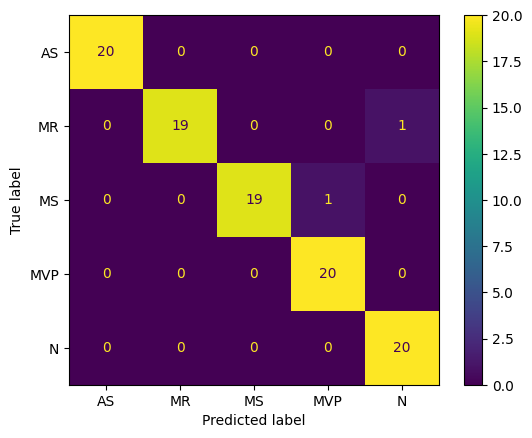

Accuracy : [1.   0.99 0.99 0.99 0.99] mean:  0.992
Precision : [1.         1.         1.         0.95238095 0.95238095] mean:  0.980952380952381
Sensitivity : [1.   0.95 0.95 1.   1.  ] mean:  0.9800000000000001
Specificity : [1.     1.     1.     0.9875 0.9875] mean:  0.9949999999999999
f1_score: [1.         0.97435897 0.97435897 0.97560976 0.97560976] mean:  0.9799874921826142



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb1L4.csv_2.h5
4/4 [==============================] - 0s 9ms/step


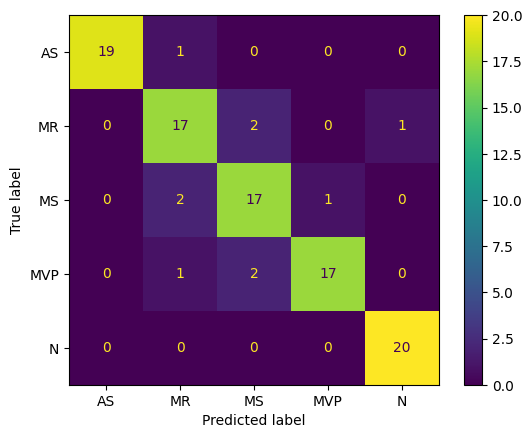

Accuracy : [0.99 0.93 0.93 0.96 0.99] mean:  0.96
Precision : [1.         0.80952381 0.80952381 0.94444444 0.95238095] mean:  0.9031746031746032
Sensitivity : [0.95 0.85 0.85 0.85 1.  ] mean:  0.9
Specificity : [1.     0.95   0.95   0.9875 0.9875] mean:  0.975
f1_score: [0.97435897 0.82926829 0.82926829 0.89473684 0.97560976] mean:  0.9006484315855303



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb1L5.csv_5.h5
4/4 [==============================] - 0s 8ms/step


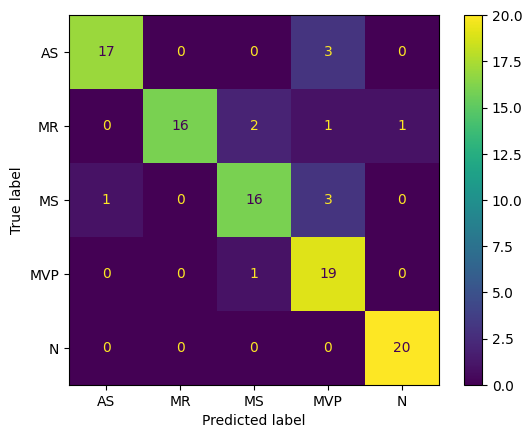

Accuracy : [0.96 0.96 0.93 0.92 0.99] mean:  0.952
Precision : [0.94444444 1.         0.84210526 0.73076923 0.95238095] mean:  0.8939399781505045
Sensitivity : [0.85 0.8  0.8  0.95 1.  ] mean:  0.8800000000000001
Specificity : [0.9875 1.     0.9625 0.9125 0.9875] mean:  0.9700000000000001
f1_score: [0.89473684 0.88888889 0.82051282 0.82608696 0.97560976] mean:  0.8811670528252545



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb1L6.csv_3.h5
4/4 [==============================] - 0s 13ms/step


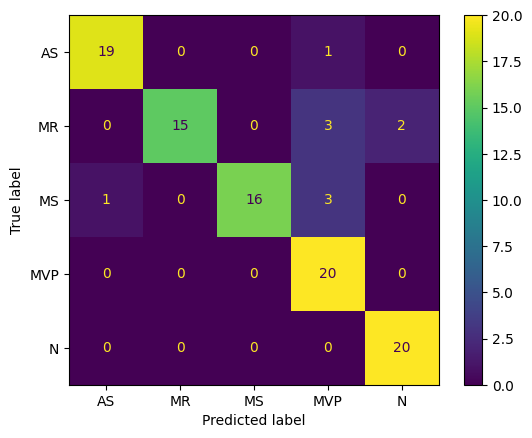

Accuracy : [0.98 0.95 0.96 0.93 0.98] mean:  0.96
Precision : [0.95       1.         1.         0.74074074 0.90909091] mean:  0.91996632996633
Sensitivity : [0.95 0.75 0.8  1.   1.  ] mean:  0.9
Specificity : [0.9875 1.     1.     0.9125 0.975 ] mean:  0.975
f1_score: [0.95       0.85714286 0.88888889 0.85106383 0.95238095] mean:  0.8998953056399864



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb1L7.csv_5.h5
4/4 [==============================] - 0s 8ms/step


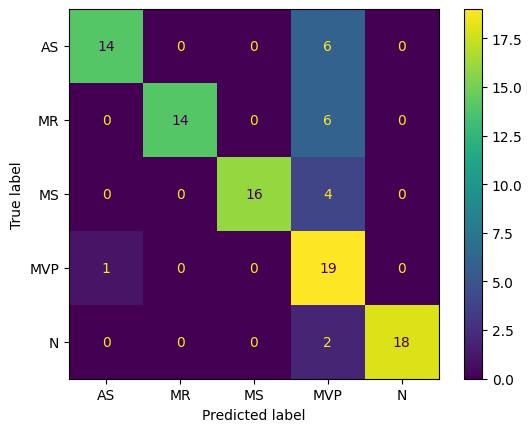

Accuracy : [0.93 0.94 0.96 0.81 0.98] mean:  0.924
Precision : [0.93333333 1.         1.         0.51351351 1.        ] mean:  0.8893693693693695
Sensitivity : [0.7  0.7  0.8  0.95 0.9 ] mean:  0.8100000000000002
Specificity : [0.9875 1.     1.     0.775  1.    ] mean:  0.9524999999999999
f1_score: [0.8        0.82352941 0.88888889 0.66666667 0.94736842] mean:  0.8252906776745788



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb1L8.csv_2.h5
4/4 [==============================] - 0s 9ms/step


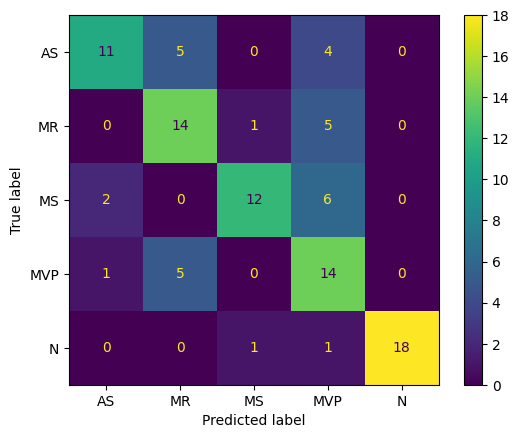

Accuracy : [0.88 0.84 0.9  0.78 0.98] mean:  0.8760000000000001
Precision : [0.78571429 0.58333333 0.85714286 0.46666667 1.        ] mean:  0.7385714285714287
Sensitivity : [0.55 0.7  0.6  0.7  0.9 ] mean:  0.69
Specificity : [0.9625 0.875  0.975  0.8    1.    ] mean:  0.9225
f1_score: [0.64705882 0.63636364 0.70588235 0.56       0.94736842] mean:  0.6993346467773712



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb1L9.csv_5.h5
4/4 [==============================] - 1s 8ms/step


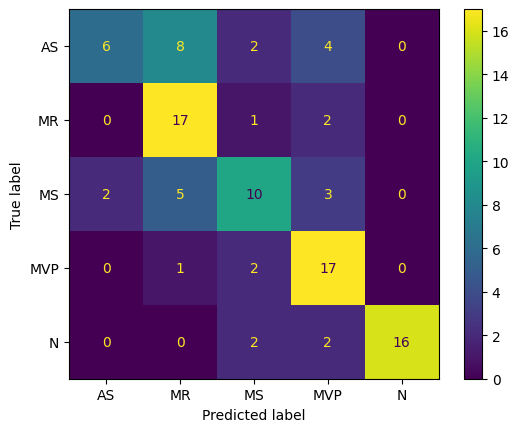

Accuracy : [0.84 0.83 0.83 0.86 0.96] mean:  0.8640000000000001
Precision : [0.75       0.5483871  0.58823529 0.60714286 1.        ] mean:  0.6987530496069396
Sensitivity : [0.3  0.85 0.5  0.85 0.8 ] mean:  0.6599999999999999
Specificity : [0.975  0.825  0.9125 0.8625 1.    ] mean:  0.915
f1_score: [0.42857143 0.66666667 0.54054054 0.70833333 0.88888889] mean:  0.6466001716001715



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb1L10.csv_4.h5
4/4 [==============================] - 0s 9ms/step


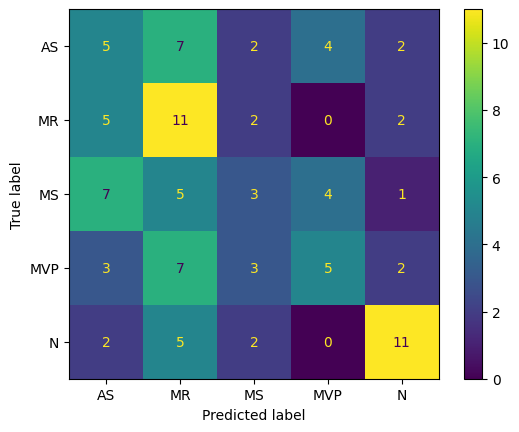

Accuracy : [0.68 0.67 0.74 0.77 0.84] mean:  0.74
Precision : [0.22727273 0.31428571 0.25       0.38461538 0.61111111] mean:  0.35745698745698745
Sensitivity : [0.25 0.55 0.15 0.25 0.55] mean:  0.35000000000000003
Specificity : [0.7875 0.7    0.8875 0.9    0.9125] mean:  0.8375
f1_score: [0.23809524 0.4        0.1875     0.3030303  0.57894737] mean:  0.3415145819093187



Accuracy All : [0.992, 0.9879999999999999, 0.992, 0.96, 0.952, 0.96, 0.924, 0.8760000000000001, 0.8640000000000001, 0.74]
Precision All : [0.9804761904761904, 0.9739130434782609, 0.980952380952381, 0.9031746031746032, 0.8939399781505045, 0.91996632996633, 0.8893693693693695, 0.7385714285714287, 0.6987530496069396, 0.35745698745698745]
Sensitivity All : [0.9800000000000001, 0.97, 0.9800000000000001, 0.9, 0.8800000000000001, 0.9, 0.8100000000000002, 0.69, 0.6599999999999999, 0.35000000000000003]
Specificity All : [0.9949999999999999, 0.9925, 0.9949999999999999, 0.975, 0.9700000000000001, 0.975, 0.9524999999999999, 0.922

In [13]:
testingVHD(a1, 1)

Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb2L1.csv_4.h5
4/4 [==============================] - 0s 8ms/step


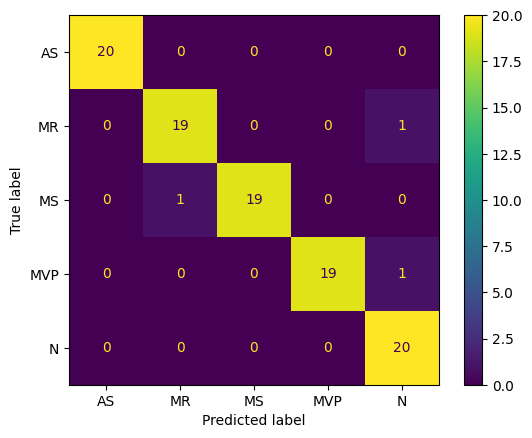

Accuracy : [1.   0.98 0.99 0.99 0.98] mean:  0.9879999999999999
Precision : [1.         0.95       1.         1.         0.90909091] mean:  0.9718181818181819
Sensitivity : [1.   0.95 0.95 0.95 1.  ] mean:  0.97
Specificity : [1.     0.9875 1.     1.     0.975 ] mean:  0.9924999999999999
f1_score: [1.         0.95       0.97435897 0.97435897 0.95238095] mean:  0.9702197802197803



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb2L2.csv_2.h5
4/4 [==============================] - 0s 8ms/step


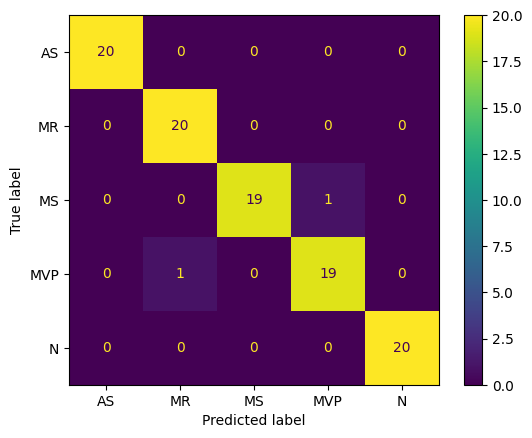

Accuracy : [1.   0.99 0.99 0.98 1.  ] mean:  0.992
Precision : [1.         0.95238095 1.         0.95       1.        ] mean:  0.9804761904761905
Sensitivity : [1.   1.   0.95 0.95 1.  ] mean:  0.9800000000000001
Specificity : [1.     0.9875 1.     0.9875 1.    ] mean:  0.9949999999999999
f1_score: [1.         0.97560976 0.97435897 0.95       1.        ] mean:  0.9799937460913071



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb2L3.csv_5.h5
4/4 [==============================] - 0s 8ms/step


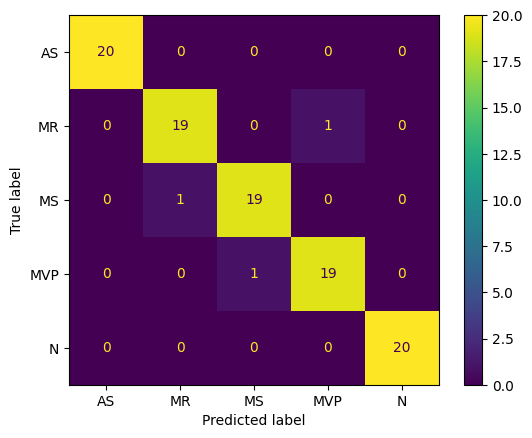

Accuracy : [1.   0.98 0.98 0.98 1.  ] mean:  0.9879999999999999
Precision : [1.   0.95 0.95 0.95 1.  ] mean:  0.97
Sensitivity : [1.   0.95 0.95 0.95 1.  ] mean:  0.97
Specificity : [1.     0.9875 0.9875 0.9875 1.    ] mean:  0.9925
f1_score: [1.   0.95 0.95 0.95 1.  ] mean:  0.9700000000000001



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb2L4.csv_2.h5
4/4 [==============================] - 0s 8ms/step


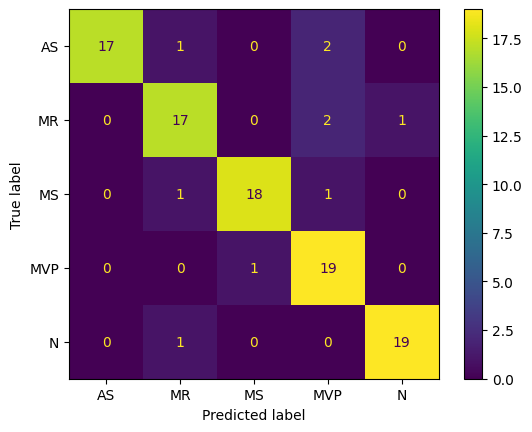

Accuracy : [0.97 0.94 0.97 0.94 0.98] mean:  0.96
Precision : [1.         0.85       0.94736842 0.79166667 0.95      ] mean:  0.9078070175438595
Sensitivity : [0.85 0.85 0.9  0.95 0.95] mean:  0.9
Specificity : [1.     0.9625 0.9875 0.9375 0.9875] mean:  0.975
f1_score: [0.91891892 0.85       0.92307692 0.86363636 0.95      ] mean:  0.9011264411264411



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb2L5.csv_5.h5
4/4 [==============================] - 0s 8ms/step


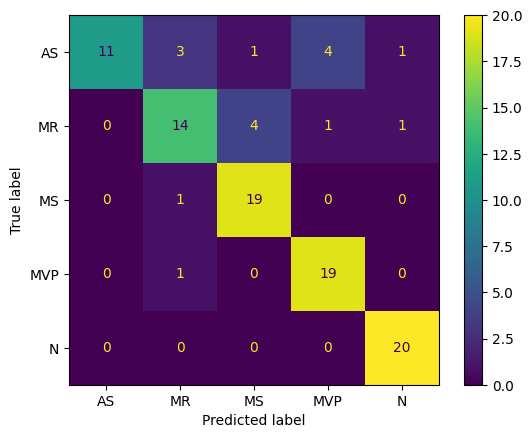

Accuracy : [0.91 0.89 0.94 0.94 0.98] mean:  0.932
Precision : [1.         0.73684211 0.79166667 0.79166667 0.90909091] mean:  0.84585326953748
Sensitivity : [0.55 0.7  0.95 0.95 1.  ] mean:  0.8300000000000001
Specificity : [1.     0.9375 0.9375 0.9375 0.975 ] mean:  0.9574999999999999
f1_score: [0.70967742 0.71794872 0.86363636 0.86363636 0.95238095] mean:  0.8214559633914472



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb2L6.csv_2.h5
4/4 [==============================] - 0s 9ms/step


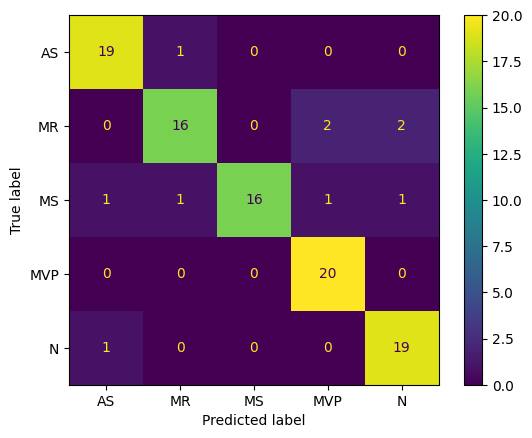

Accuracy : [0.97 0.94 0.96 0.97 0.96] mean:  0.96
Precision : [0.9047619  0.88888889 1.         0.86956522 0.86363636] mean:  0.9053704749356923
Sensitivity : [0.95 0.8  0.8  1.   0.95] mean:  0.9
Specificity : [0.975  0.975  1.     0.9625 0.9625] mean:  0.975
f1_score: [0.92682927 0.84210526 0.88888889 0.93023256 0.9047619 ] mean:  0.8985635766481812



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb2L7.csv_2.h5
4/4 [==============================] - 0s 8ms/step


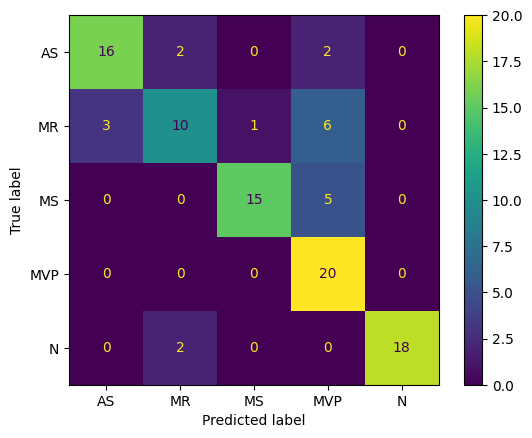

Accuracy : [0.93 0.86 0.94 0.87 0.98] mean:  0.916
Precision : [0.84210526 0.71428571 0.9375     0.60606061 1.        ] mean:  0.8199903167008429
Sensitivity : [0.8  0.5  0.75 1.   0.9 ] mean:  0.7899999999999999
Specificity : [0.9625 0.95   0.9875 0.8375 1.    ] mean:  0.9475000000000001
f1_score: [0.82051282 0.58823529 0.83333333 0.75471698 0.94736842] mean:  0.7888333700297017



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb2L8.csv_5.h5
4/4 [==============================] - 0s 8ms/step


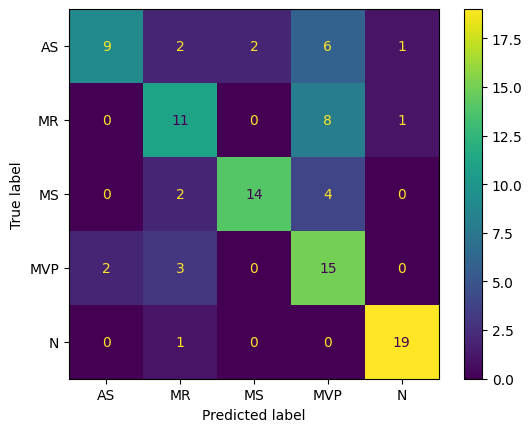

Accuracy : [0.87 0.83 0.92 0.77 0.97] mean:  0.8720000000000001
Precision : [0.81818182 0.57894737 0.875      0.45454545 0.9047619 ] mean:  0.7262873091820461
Sensitivity : [0.45 0.55 0.7  0.75 0.95] mean:  0.68
Specificity : [0.975 0.9   0.975 0.775 0.975] mean:  0.9199999999999999
f1_score: [0.58064516 0.56410256 0.77777778 0.56603774 0.92682927] mean:  0.6830785014624807



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb2L9.csv_2.h5
4/4 [==============================] - 0s 8ms/step


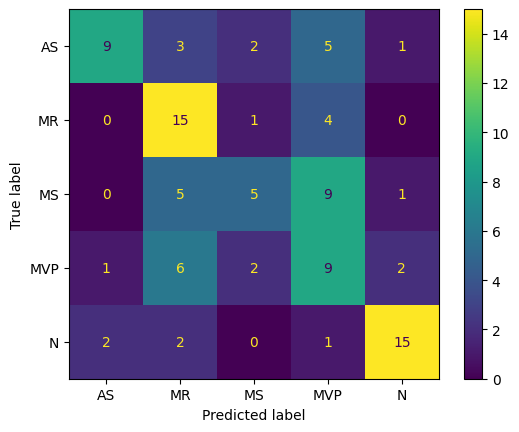

Accuracy : [0.86 0.79 0.8  0.7  0.91] mean:  0.812
Precision : [0.75       0.48387097 0.5        0.32142857 0.78947368] mean:  0.5689546446762067
Sensitivity : [0.45 0.75 0.25 0.45 0.75] mean:  0.53
Specificity : [0.9625 0.8    0.9375 0.7625 0.95  ] mean:  0.8825000000000001
f1_score: [0.5625     0.58823529 0.33333333 0.375      0.76923077] mean:  0.5256598793363499



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb2L10.csv_1.h5
4/4 [==============================] - 0s 9ms/step


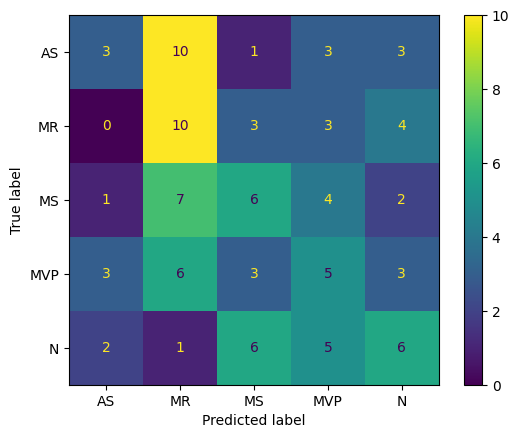

Accuracy : [0.77 0.66 0.73 0.7  0.74] mean:  0.7200000000000001
Precision : [0.33333333 0.29411765 0.31578947 0.25       0.33333333] mean:  0.30531475748194015
Sensitivity : [0.15 0.5  0.3  0.25 0.3 ] mean:  0.3
Specificity : [0.925  0.7    0.8375 0.8125 0.85  ] mean:  0.825
f1_score: [0.20689655 0.37037037 0.30769231 0.25       0.31578947] mean:  0.29014974069420535



Accuracy All : [0.9879999999999999, 0.992, 0.9879999999999999, 0.96, 0.932, 0.96, 0.916, 0.8720000000000001, 0.812, 0.7200000000000001]
Precision All : [0.9718181818181819, 0.9804761904761905, 0.97, 0.9078070175438595, 0.84585326953748, 0.9053704749356923, 0.8199903167008429, 0.7262873091820461, 0.5689546446762067, 0.30531475748194015]
Sensitivity All : [0.97, 0.9800000000000001, 0.97, 0.9, 0.8300000000000001, 0.9, 0.7899999999999999, 0.68, 0.53, 0.3]
Specificity All : [0.9924999999999999, 0.9949999999999999, 0.9925, 0.975, 0.9574999999999999, 0.975, 0.9475000000000001, 0.9199999999999999, 0.8825000000000001, 0.825]
f1_

In [14]:
testingVHD(a2, 2)

Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb3L1.csv_2.h5
4/4 [==============================] - 0s 8ms/step


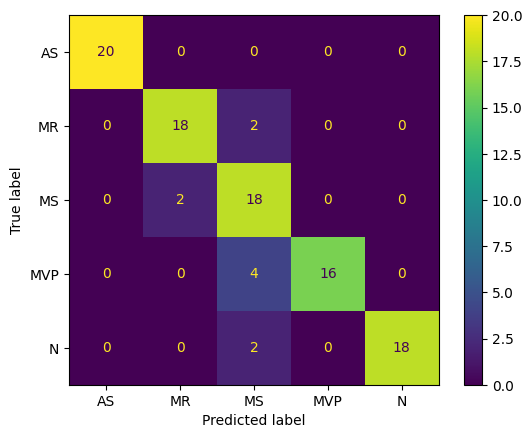

Accuracy : [1.   0.96 0.9  0.96 0.98] mean:  0.96
Precision : [1.         0.9        0.69230769 1.         1.        ] mean:  0.9184615384615384
Sensitivity : [1.  0.9 0.9 0.8 0.9] mean:  0.9
Specificity : [1.    0.975 0.9   1.    1.   ] mean:  0.975
f1_score: [1.         0.9        0.7826087  0.88888889 0.94736842] mean:  0.9037732011187389



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb3L2.csv_5.h5
4/4 [==============================] - 0s 9ms/step


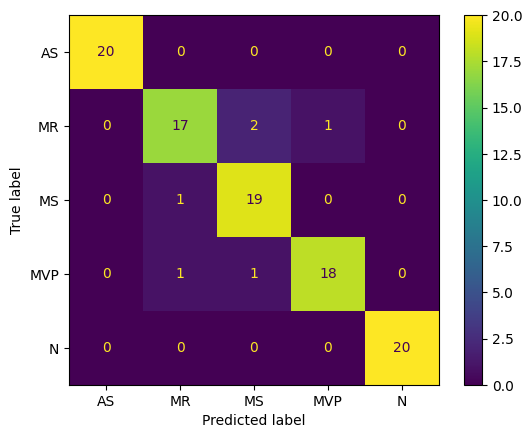

Accuracy : [1.   0.95 0.96 0.97 1.  ] mean:  0.976
Precision : [1.         0.89473684 0.86363636 0.94736842 1.        ] mean:  0.9411483253588517
Sensitivity : [1.   0.85 0.95 0.9  1.  ] mean:  0.9399999999999998
Specificity : [1.     0.975  0.9625 0.9875 1.    ] mean:  0.985
f1_score: [1.         0.87179487 0.9047619  0.92307692 1.        ] mean:  0.9399267399267399



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb3L3.csv_2.h5
4/4 [==============================] - 0s 8ms/step


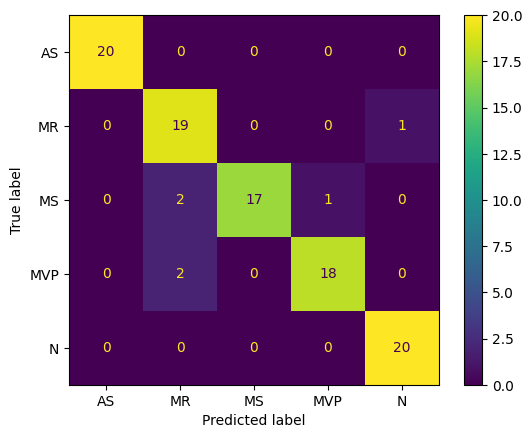

Accuracy : [1.   0.95 0.97 0.97 0.99] mean:  0.976
Precision : [1.         0.82608696 1.         0.94736842 0.95238095] mean:  0.9451672659910646
Sensitivity : [1.   0.95 0.85 0.9  1.  ] mean:  0.9399999999999998
Specificity : [1.     0.95   1.     0.9875 0.9875] mean:  0.985
f1_score: [1.         0.88372093 0.91891892 0.92307692 0.97560976] mean:  0.9402653056651923



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb3L4.csv_2.h5
4/4 [==============================] - 0s 9ms/step


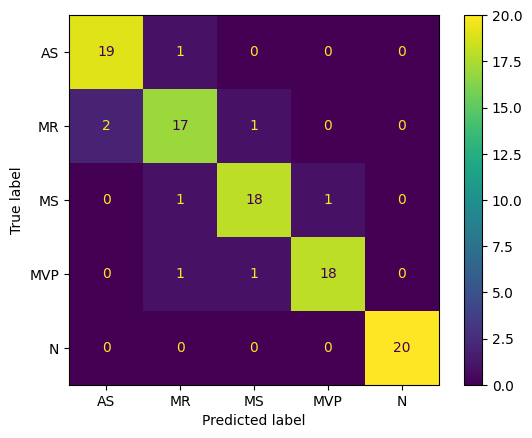

Accuracy : [0.97 0.94 0.96 0.97 1.  ] mean:  0.968
Precision : [0.9047619  0.85       0.9        0.94736842 1.        ] mean:  0.9204260651629073
Sensitivity : [0.95 0.85 0.9  0.9  1.  ] mean:  0.9199999999999999
Specificity : [0.975  0.9625 0.975  0.9875 1.    ] mean:  0.9800000000000001
f1_score: [0.92682927 0.85       0.9        0.92307692 1.        ] mean:  0.9199812382739212



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb3L5.csv_2.h5
4/4 [==============================] - 0s 8ms/step


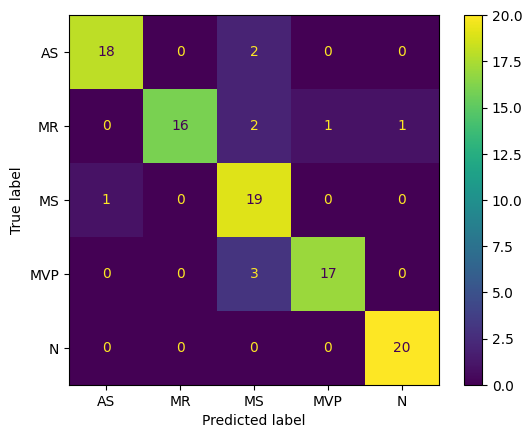

Accuracy : [0.97 0.96 0.92 0.96 0.99] mean:  0.96
Precision : [0.94736842 1.         0.73076923 0.94444444 0.95238095] mean:  0.9149926097294518
Sensitivity : [0.9  0.8  0.95 0.85 1.  ] mean:  0.9
Specificity : [0.9875 1.     0.9125 0.9875 0.9875] mean:  0.975
f1_score: [0.92307692 0.88888889 0.82608696 0.89473684 0.97560976] mean:  0.9016798733380751



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb3L6.csv_2.h5
4/4 [==============================] - 0s 9ms/step


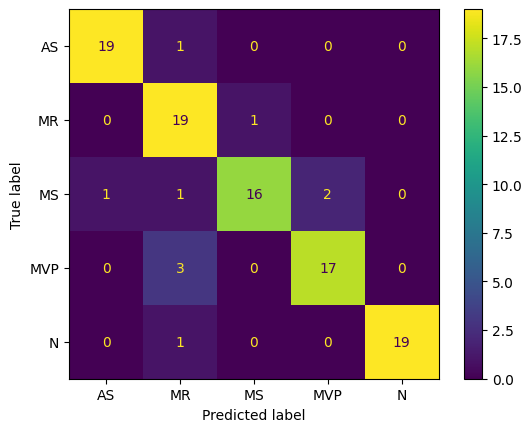

Accuracy : [0.98 0.93 0.95 0.95 0.99] mean:  0.9600000000000002
Precision : [0.95       0.76       0.94117647 0.89473684 1.        ] mean:  0.9091826625386996
Sensitivity : [0.95 0.95 0.8  0.85 0.95] mean:  0.9
Specificity : [0.9875 0.925  0.9875 0.975  1.    ] mean:  0.975
f1_score: [0.95       0.84444444 0.86486486 0.87179487 0.97435897] mean:  0.901092631092631



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb3L7.csv_5.h5
4/4 [==============================] - 0s 8ms/step


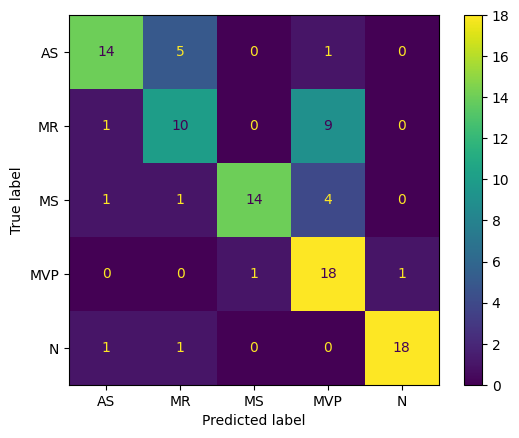

Accuracy : [0.91 0.83 0.93 0.84 0.97] mean:  0.8959999999999999
Precision : [0.82352941 0.58823529 0.93333333 0.5625     0.94736842] mean:  0.7709932920536635
Sensitivity : [0.7 0.5 0.7 0.9 0.9] mean:  0.74
Specificity : [0.9625 0.9125 0.9875 0.825  0.9875] mean:  0.9349999999999999
f1_score: [0.75675676 0.54054054 0.8        0.69230769 0.92307692] mean:  0.7425363825363827



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb3L8.csv_5.h5
4/4 [==============================] - 0s 9ms/step


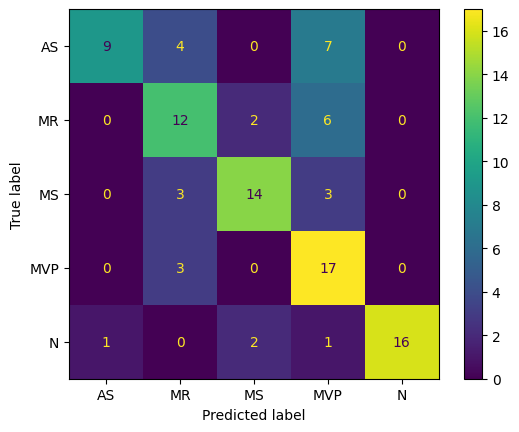

Accuracy : [0.88 0.82 0.9  0.8  0.96] mean:  0.8720000000000001
Precision : [0.9        0.54545455 0.77777778 0.5        1.        ] mean:  0.7446464646464646
Sensitivity : [0.45 0.6  0.7  0.85 0.8 ] mean:  0.68
Specificity : [0.9875 0.875  0.95   0.7875 1.    ] mean:  0.9199999999999999
f1_score: [0.6        0.57142857 0.73684211 0.62962963 0.88888889] mean:  0.6853578390420495



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb3L9.csv_3.h5
4/4 [==============================] - 0s 8ms/step


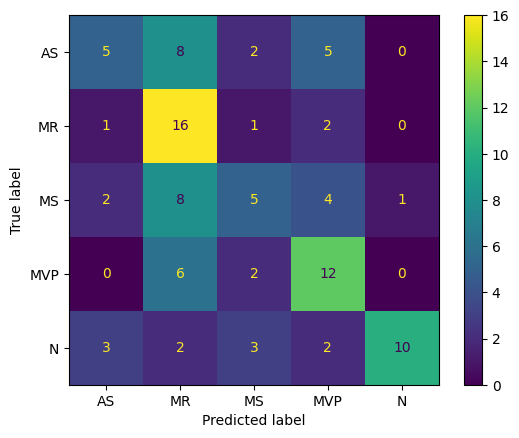

Accuracy : [0.79 0.72 0.77 0.79 0.89] mean:  0.792
Precision : [0.45454545 0.4        0.38461538 0.48       0.90909091] mean:  0.5256503496503496
Sensitivity : [0.25 0.8  0.25 0.6  0.5 ] mean:  0.48
Specificity : [0.925  0.7    0.9    0.8375 0.9875] mean:  0.8699999999999999
f1_score: [0.32258065 0.53333333 0.3030303  0.53333333 0.64516129] mean:  0.4674877810361681



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb3L10.csv_5.h5
4/4 [==============================] - 0s 8ms/step


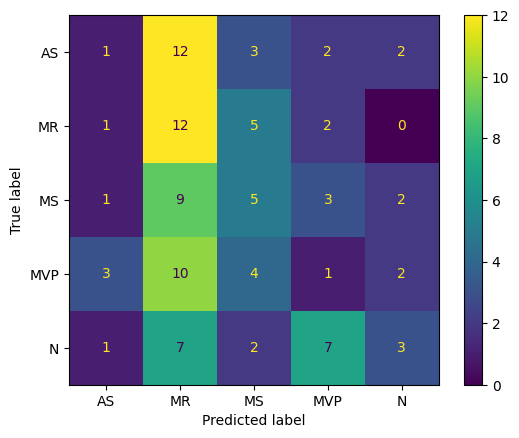

Accuracy : [0.75 0.54 0.71 0.67 0.77] mean:  0.688
Precision : [0.14285714 0.24       0.26315789 0.06666667 0.33333333] mean:  0.209203007518797
Sensitivity : [0.05 0.6  0.25 0.05 0.15] mean:  0.22000000000000003
Specificity : [0.925 0.525 0.825 0.825 0.925] mean:  0.805
f1_score: [0.07407407 0.34285714 0.25641026 0.05714286 0.20689655] mean:  0.18747617644169368



Accuracy All : [0.96, 0.976, 0.976, 0.968, 0.96, 0.9600000000000002, 0.8959999999999999, 0.8720000000000001, 0.792, 0.688]
Precision All : [0.9184615384615384, 0.9411483253588517, 0.9451672659910646, 0.9204260651629073, 0.9149926097294518, 0.9091826625386996, 0.7709932920536635, 0.7446464646464646, 0.5256503496503496, 0.209203007518797]
Sensitivity All : [0.9, 0.9399999999999998, 0.9399999999999998, 0.9199999999999999, 0.9, 0.9, 0.74, 0.68, 0.48, 0.22000000000000003]
Specificity All : [0.975, 0.985, 0.985, 0.9800000000000001, 0.975, 0.975, 0.9349999999999999, 0.9199999999999999, 0.8699999999999999, 0.805]
f1_score All : [0.

In [15]:
testingVHD(a3, 3)

Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb4L1.csv_3.h5


4/4 [==============================] - 0s 8ms/step


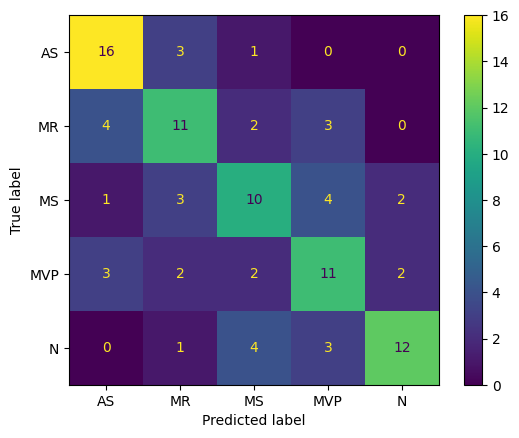

Accuracy : [0.88 0.82 0.81 0.81 0.88] mean:  0.8400000000000001
Precision : [0.66666667 0.55       0.52631579 0.52380952 0.75      ] mean:  0.6033583959899749
Sensitivity : [0.8  0.55 0.5  0.55 0.6 ] mean:  0.6000000000000001
Specificity : [0.9    0.8875 0.8875 0.875  0.95  ] mean:  0.9
f1_score: [0.72727273 0.55       0.51282051 0.53658537 0.66666667] mean:  0.598669054522713



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb4L2.csv_4.h5
4/4 [==============================] - 0s 8ms/step


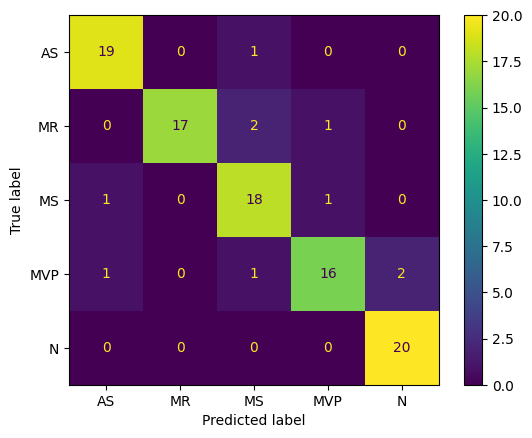

Accuracy : [0.97 0.97 0.94 0.94 0.98] mean:  0.96
Precision : [0.9047619  1.         0.81818182 0.88888889 0.90909091] mean:  0.9041847041847042
Sensitivity : [0.95 0.85 0.9  0.8  1.  ] mean:  0.9
Specificity : [0.975 1.    0.95  0.975 0.975] mean:  0.975
f1_score: [0.92682927 0.91891892 0.85714286 0.84210526 0.95238095] mean:  0.8994754519786612



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb4L3.csv_2.h5
4/4 [==============================] - 0s 8ms/step


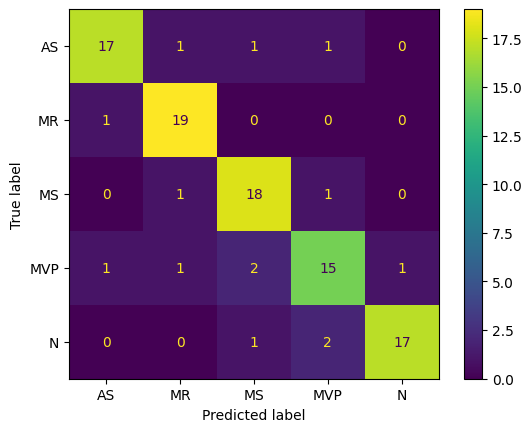

Accuracy : [0.95 0.96 0.94 0.91 0.96] mean:  0.944
Precision : [0.89473684 0.86363636 0.81818182 0.78947368 0.94444444] mean:  0.8620946305156831
Sensitivity : [0.85 0.95 0.9  0.75 0.85] mean:  0.86
Specificity : [0.975  0.9625 0.95   0.95   0.9875] mean:  0.9650000000000001
f1_score: [0.87179487 0.9047619  0.85714286 0.76923077 0.89473684] mean:  0.8595334490071332



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb4L4.csv_5.h5
4/4 [==============================] - 0s 9ms/step


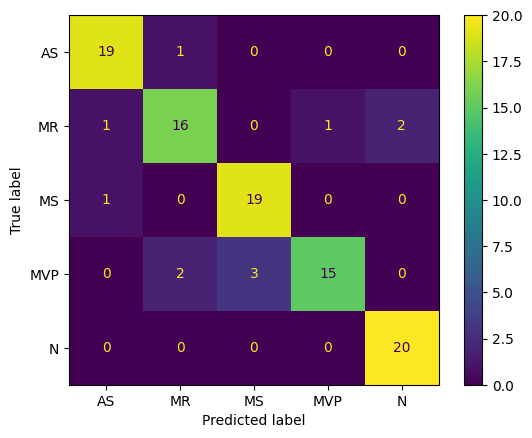

Accuracy : [0.97 0.93 0.96 0.94 0.98] mean:  0.9559999999999998
Precision : [0.9047619  0.84210526 0.86363636 0.9375     0.90909091] mean:  0.8914188881294145
Sensitivity : [0.95 0.8  0.95 0.75 1.  ] mean:  0.89
Specificity : [0.975  0.9625 0.9625 0.9875 0.975 ] mean:  0.9724999999999999
f1_score: [0.92682927 0.82051282 0.9047619  0.83333333 0.95238095] mean:  0.8875636558563388



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb4L5.csv_2.h5
4/4 [==============================] - 0s 9ms/step


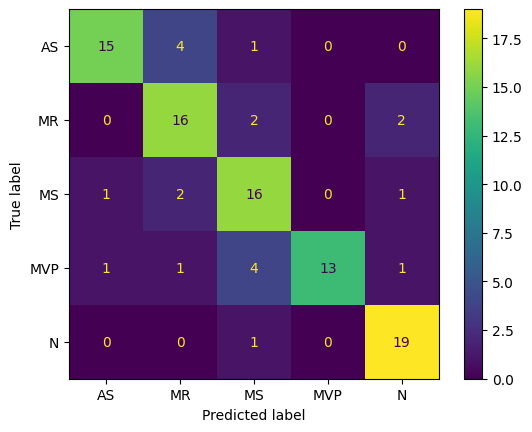

Accuracy : [0.93 0.89 0.88 0.93 0.95] mean:  0.916
Precision : [0.88235294 0.69565217 0.66666667 1.         0.82608696] mean:  0.8141517476555838
Sensitivity : [0.75 0.8  0.8  0.65 0.95] mean:  0.79
Specificity : [0.975  0.9125 0.9    1.     0.95  ] mean:  0.9475
f1_score: [0.81081081 0.74418605 0.72727273 0.78787879 0.88372093] mean:  0.7907738605413025



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb4L6.csv_2.h5
4/4 [==============================] - 0s 9ms/step


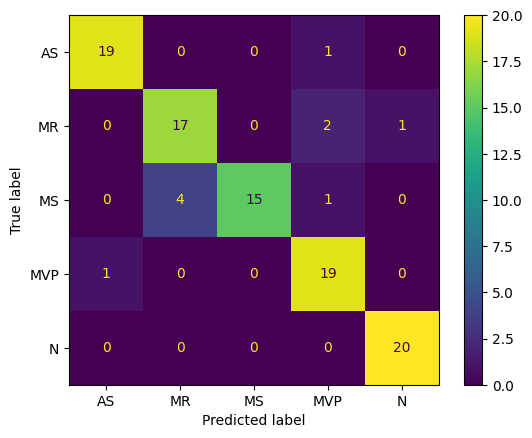

Accuracy : [0.98 0.93 0.95 0.95 0.99] mean:  0.9600000000000002
Precision : [0.95       0.80952381 1.         0.82608696 0.95238095] mean:  0.9075983436853002
Sensitivity : [0.95 0.85 0.75 0.95 1.  ] mean:  0.9
Specificity : [0.9875 0.95   1.     0.95   0.9875] mean:  0.975
f1_score: [0.95       0.82926829 0.85714286 0.88372093 0.97560976] mean:  0.8991483672311806



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb4L7.csv_5.h5
4/4 [==============================] - 0s 8ms/step


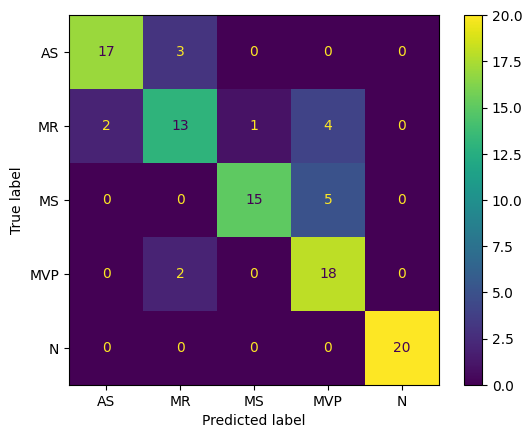

Accuracy : [0.95 0.88 0.94 0.89 1.  ] mean:  0.932
Precision : [0.89473684 0.72222222 0.9375     0.66666667 1.        ] mean:  0.8442251461988303
Sensitivity : [0.85 0.65 0.75 0.9  1.  ] mean:  0.8300000000000001
Specificity : [0.975  0.9375 0.9875 0.8875 1.    ] mean:  0.9575000000000001
f1_score: [0.87179487 0.68421053 0.83333333 0.76595745 1.        ] mean:  0.831059235650501



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb4L8.csv_3.h5
4/4 [==============================] - 0s 9ms/step


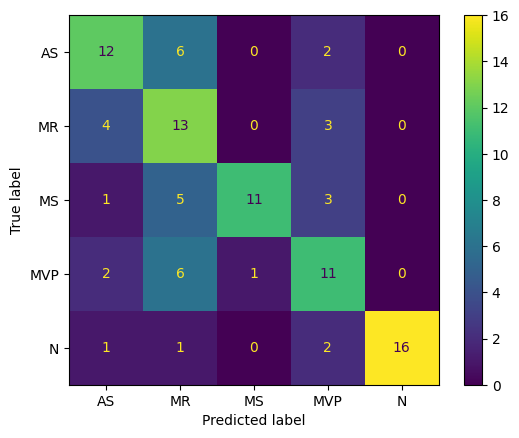

Accuracy : [0.84 0.75 0.9  0.81 0.96] mean:  0.852
Precision : [0.6        0.41935484 0.91666667 0.52380952 1.        ] mean:  0.6919662058371736
Sensitivity : [0.6  0.65 0.55 0.55 0.8 ] mean:  0.6300000000000001
Specificity : [0.9    0.775  0.9875 0.875  1.    ] mean:  0.9075
f1_score: [0.6        0.50980392 0.6875     0.53658537 0.88888889] mean:  0.644555635262235



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb4L9.csv_2.h5
4/4 [==============================] - 0s 8ms/step


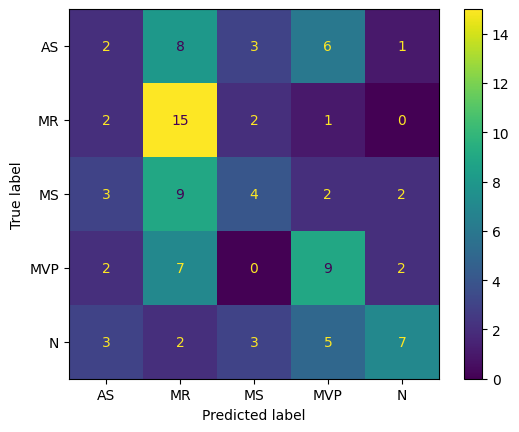

Accuracy : [0.72 0.69 0.76 0.75 0.82] mean:  0.748
Precision : [0.16666667 0.36585366 0.33333333 0.39130435 0.58333333] mean:  0.36809826793920114
Sensitivity : [0.1  0.75 0.2  0.45 0.35] mean:  0.37
Specificity : [0.875  0.675  0.9    0.825  0.9375] mean:  0.8425
f1_score: [0.125      0.49180328 0.25       0.41860465 0.4375    ] mean:  0.3445815859702631



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb4L10.csv_5.h5
4/4 [==============================] - 0s 8ms/step


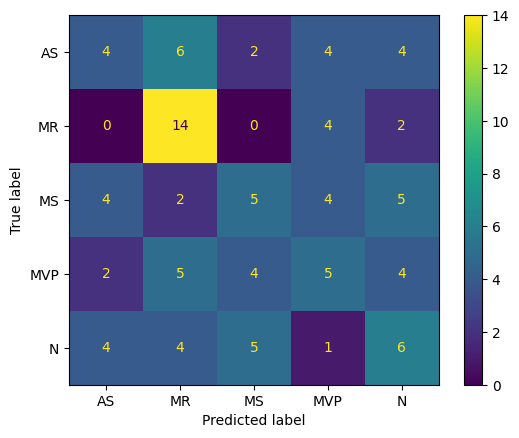

Accuracy : [0.74 0.77 0.74 0.72 0.71] mean:  0.736
Precision : [0.28571429 0.4516129  0.3125     0.27777778 0.28571429] mean:  0.3226638504864311
Sensitivity : [0.2  0.7  0.25 0.25 0.3 ] mean:  0.33999999999999997
Specificity : [0.875  0.7875 0.8625 0.8375 0.8125] mean:  0.8350000000000002
f1_score: [0.23529412 0.54901961 0.27777778 0.26315789 0.29268293] mean:  0.3235864649668168



Accuracy All : [0.8400000000000001, 0.96, 0.944, 0.9559999999999998, 0.916, 0.9600000000000002, 0.932, 0.852, 0.748, 0.736]
Precision All : [0.6033583959899749, 0.9041847041847042, 0.8620946305156831, 0.8914188881294145, 0.8141517476555838, 0.9075983436853002, 0.8442251461988303, 0.6919662058371736, 0.36809826793920114, 0.3226638504864311]
Sensitivity All : [0.6000000000000001, 0.9, 0.86, 0.89, 0.79, 0.9, 0.8300000000000001, 0.6300000000000001, 0.37, 0.33999999999999997]
Specificity All : [0.9, 0.975, 0.9650000000000001, 0.9724999999999999, 0.9475, 0.975, 0.9575000000000001, 0.9075, 0.8425, 0.8350000000000

In [16]:
testingVHD(a4, 4)

Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb5L1.csv_5.h5


4/4 [==============================] - 0s 8ms/step


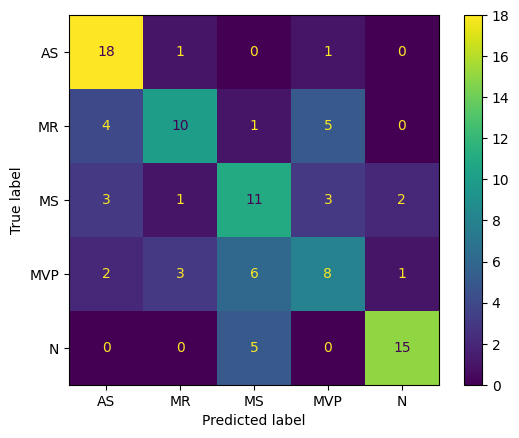

Accuracy : [0.89 0.85 0.79 0.79 0.92] mean:  0.8480000000000001
Precision : [0.66666667 0.66666667 0.47826087 0.47058824 0.83333333] mean:  0.6231031543052004
Sensitivity : [0.9  0.5  0.55 0.4  0.75] mean:  0.62
Specificity : [0.8875 0.9375 0.85   0.8875 0.9625] mean:  0.905
f1_score: [0.76595745 0.57142857 0.51162791 0.43243243 0.78947368] mean:  0.614184008371357



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb5L2.csv_2.h5
4/4 [==============================] - 0s 9ms/step


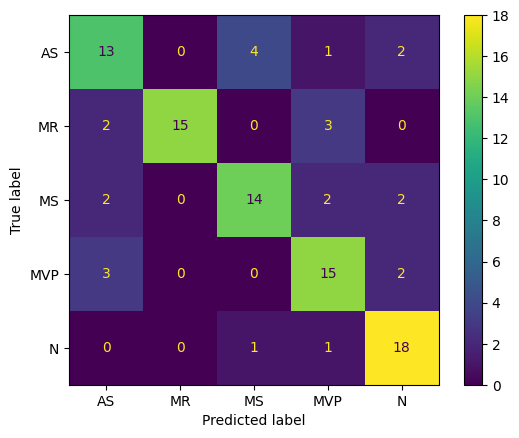

Accuracy : [0.86 0.95 0.89 0.88 0.92] mean:  0.9
Precision : [0.65       1.         0.73684211 0.68181818 0.75      ] mean:  0.7637320574162679
Sensitivity : [0.65 0.75 0.7  0.75 0.9 ] mean:  0.7499999999999999
Specificity : [0.9125 1.     0.9375 0.9125 0.925 ] mean:  0.9375
f1_score: [0.65       0.85714286 0.71794872 0.71428571 0.81818182] mean:  0.7515118215118216



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb5L3.csv_2.h5
4/4 [==============================] - 0s 8ms/step


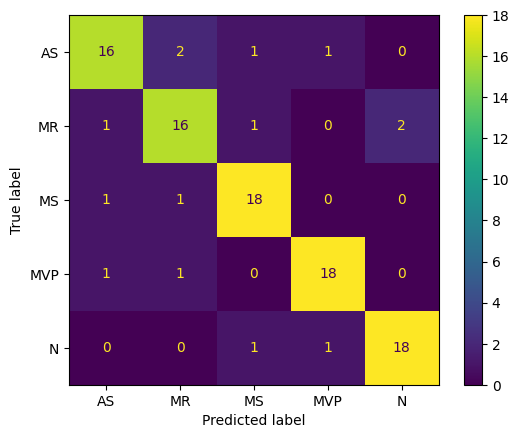

Accuracy : [0.93 0.92 0.95 0.96 0.96] mean:  0.944
Precision : [0.84210526 0.8        0.85714286 0.9        0.9       ] mean:  0.8598496240601504
Sensitivity : [0.8 0.8 0.9 0.9 0.9] mean:  0.86
Specificity : [0.9625 0.95   0.9625 0.975  0.975 ] mean:  0.9650000000000001
f1_score: [0.82051282 0.8        0.87804878 0.9        0.9       ] mean:  0.8597123202001251



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb5L4.csv_2.h5
4/4 [==============================] - 0s 9ms/step


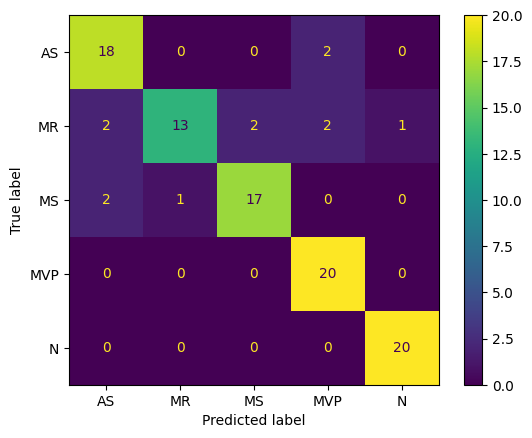

Accuracy : [0.94 0.92 0.95 0.96 0.99] mean:  0.952
Precision : [0.81818182 0.92857143 0.89473684 0.83333333 0.95238095] mean:  0.8854408749145591
Sensitivity : [0.9  0.65 0.85 1.   1.  ] mean:  0.8800000000000001
Specificity : [0.95   0.9875 0.975  0.95   0.9875] mean:  0.97
f1_score: [0.85714286 0.76470588 0.87179487 0.90909091 0.97560976] mean:  0.875668855295828



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb5L5.csv_2.h5
4/4 [==============================] - 0s 8ms/step


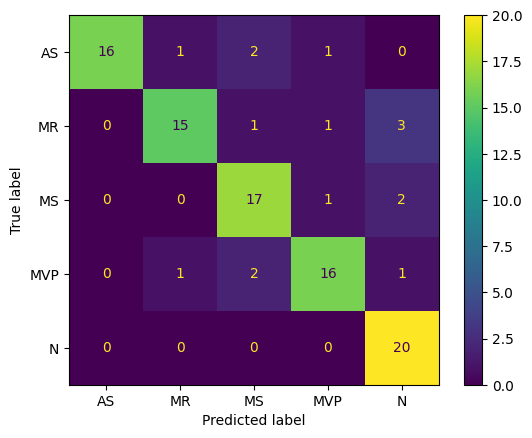

Accuracy : [0.96 0.93 0.92 0.93 0.94] mean:  0.9359999999999999
Precision : [1.         0.88235294 0.77272727 0.84210526 0.76923077] mean:  0.8532832492584814
Sensitivity : [0.8  0.75 0.85 0.8  1.  ] mean:  0.8400000000000001
Specificity : [1.     0.975  0.9375 0.9625 0.925 ] mean:  0.96
f1_score: [0.88888889 0.81081081 0.80952381 0.82051282 0.86956522] mean:  0.8398603094255268



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb5L6.csv_5.h5
4/4 [==============================] - 0s 8ms/step


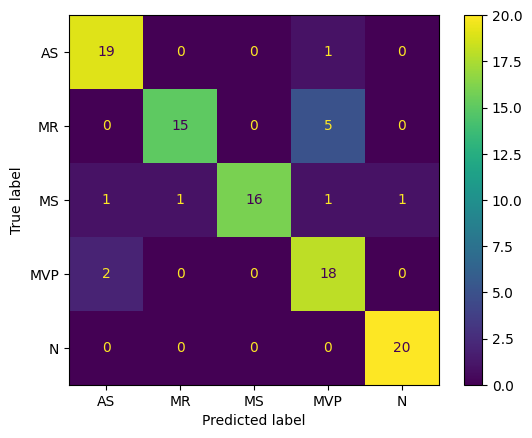

Accuracy : [0.96 0.94 0.96 0.91 0.99] mean:  0.952
Precision : [0.86363636 0.9375     1.         0.72       0.95238095] mean:  0.8947034632034633
Sensitivity : [0.95 0.75 0.8  0.9  1.  ] mean:  0.8800000000000001
Specificity : [0.9625 0.9875 1.     0.9125 0.9875] mean:  0.9700000000000001
f1_score: [0.9047619  0.83333333 0.88888889 0.8        0.97560976] mean:  0.8805187766163375



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb5L7.csv_3.h5
4/4 [==============================] - 0s 8ms/step


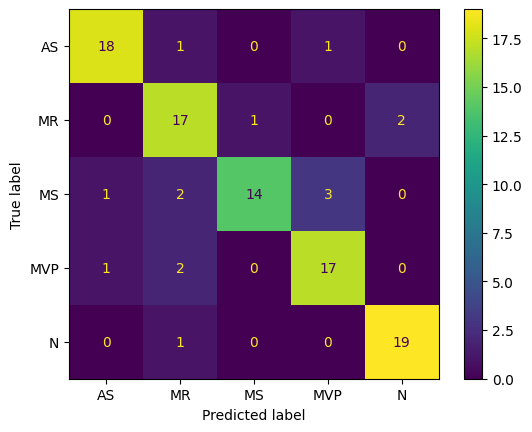

Accuracy : [0.96 0.91 0.93 0.93 0.97] mean:  0.9400000000000001
Precision : [0.9        0.73913043 0.93333333 0.80952381 0.9047619 ] mean:  0.8573498964803313
Sensitivity : [0.9  0.85 0.7  0.85 0.95] mean:  0.85
Specificity : [0.975  0.925  0.9875 0.95   0.975 ] mean:  0.9625
f1_score: [0.9        0.79069767 0.8        0.82926829 0.92682927] mean:  0.8493590470788428



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb5L8.csv_2.h5
4/4 [==============================] - 0s 8ms/step


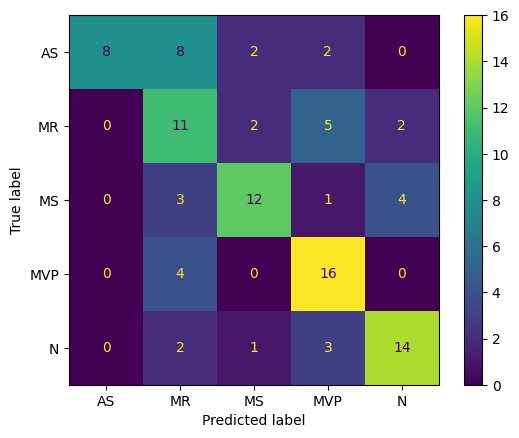

Accuracy : [0.88 0.74 0.87 0.85 0.88] mean:  0.8440000000000001
Precision : [1.         0.39285714 0.70588235 0.59259259 0.7       ] mean:  0.6782664176781823
Sensitivity : [0.4  0.55 0.6  0.8  0.7 ] mean:  0.61
Specificity : [1.     0.7875 0.9375 0.8625 0.925 ] mean:  0.9025000000000001
f1_score: [0.57142857 0.45833333 0.64864865 0.68085106 0.7       ] mean:  0.6118523234480682



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb5L9.csv_3.h5
4/4 [==============================] - 0s 8ms/step


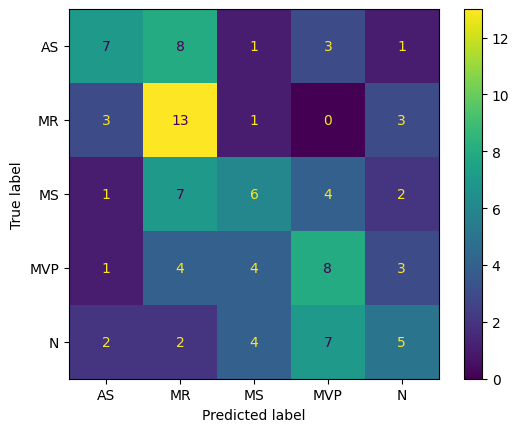

Accuracy : [0.8  0.72 0.76 0.74 0.76] mean:  0.756
Precision : [0.5        0.38235294 0.375      0.36363636 0.35714286] mean:  0.3956264323911383
Sensitivity : [0.35 0.65 0.3  0.4  0.25] mean:  0.39
Specificity : [0.9125 0.7375 0.875  0.825  0.8875] mean:  0.8474999999999999
f1_score: [0.41176471 0.48148148 0.33333333 0.38095238 0.29411765] mean:  0.3803299097416744



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb5L10.csv_5.h5
4/4 [==============================] - 0s 8ms/step


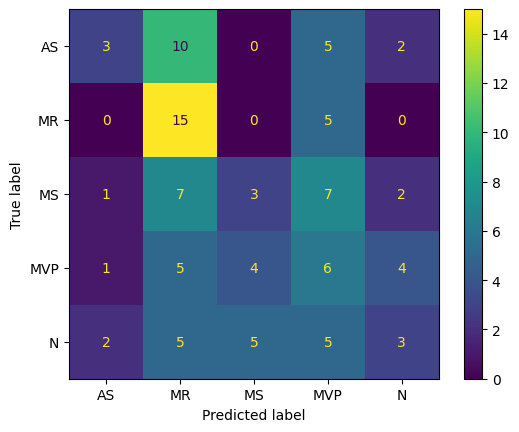

Accuracy : [0.79 0.68 0.74 0.64 0.75] mean:  0.72
Precision : [0.42857143 0.35714286 0.25       0.21428571 0.27272727] mean:  0.3045454545454545
Sensitivity : [0.15 0.75 0.15 0.3  0.15] mean:  0.3
Specificity : [0.95   0.6625 0.8875 0.725  0.9   ] mean:  0.825
f1_score: [0.22222222 0.48387097 0.1875     0.25       0.19354839] mean:  0.26742831541218637



Accuracy All : [0.8480000000000001, 0.9, 0.944, 0.952, 0.9359999999999999, 0.952, 0.9400000000000001, 0.8440000000000001, 0.756, 0.72]
Precision All : [0.6231031543052004, 0.7637320574162679, 0.8598496240601504, 0.8854408749145591, 0.8532832492584814, 0.8947034632034633, 0.8573498964803313, 0.6782664176781823, 0.3956264323911383, 0.3045454545454545]
Sensitivity All : [0.62, 0.7499999999999999, 0.86, 0.8800000000000001, 0.8400000000000001, 0.8800000000000001, 0.85, 0.61, 0.39, 0.3]
Specificity All : [0.905, 0.9375, 0.9650000000000001, 0.97, 0.96, 0.9700000000000001, 0.9625, 0.9025000000000001, 0.8474999999999999, 0.825]
f1_score All : 

In [17]:
testingVHD(a5, 5)

Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb6L1.csv_5.h5


4/4 [==============================] - 0s 8ms/step


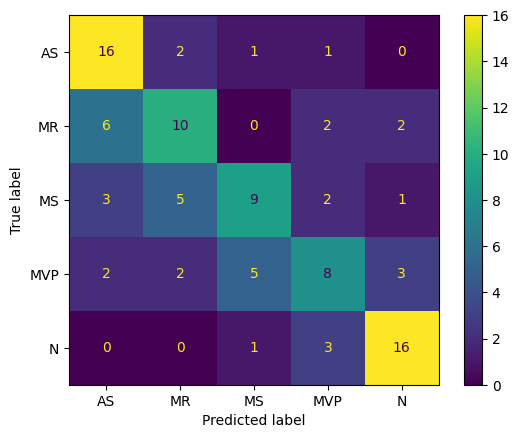

Accuracy : [0.85 0.81 0.82 0.8  0.9 ] mean:  0.8360000000000001
Precision : [0.59259259 0.52631579 0.5625     0.5        0.72727273] mean:  0.5817362218678008
Sensitivity : [0.8  0.5  0.45 0.4  0.8 ] mean:  0.5900000000000001
Specificity : [0.8625 0.8875 0.9125 0.9    0.925 ] mean:  0.8975
f1_score: [0.68085106 0.51282051 0.5        0.44444444 0.76190476] mean:  0.5800041565999013



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb6L2.csv_4.h5
4/4 [==============================] - 0s 8ms/step


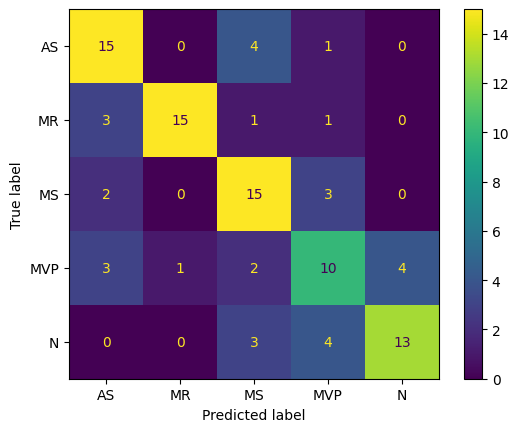

Accuracy : [0.87 0.94 0.85 0.81 0.89] mean:  0.8720000000000001
Precision : [0.65217391 0.9375     0.6        0.52631579 0.76470588] mean:  0.6961391169740206
Sensitivity : [0.75 0.75 0.75 0.5  0.65] mean:  0.6799999999999999
Specificity : [0.9    0.9875 0.875  0.8875 0.95  ] mean:  0.9200000000000002
f1_score: [0.69767442 0.83333333 0.66666667 0.51282051 0.7027027 ] mean:  0.6826395268255733



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb6L3.csv_2.h5
4/4 [==============================] - 0s 8ms/step


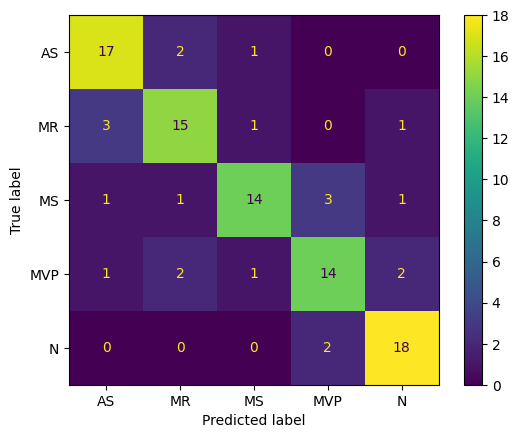

Accuracy : [0.92 0.9  0.91 0.89 0.94] mean:  0.9120000000000001
Precision : [0.77272727 0.75       0.82352941 0.73684211 0.81818182] mean:  0.780256121587391
Sensitivity : [0.85 0.75 0.7  0.7  0.9 ] mean:  0.78
Specificity : [0.9375 0.9375 0.9625 0.9375 0.95  ] mean:  0.945
f1_score: [0.80952381 0.75       0.75675676 0.71794872 0.85714286] mean:  0.7782744282744283



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb6L4.csv_2.h5
4/4 [==============================] - 0s 9ms/step


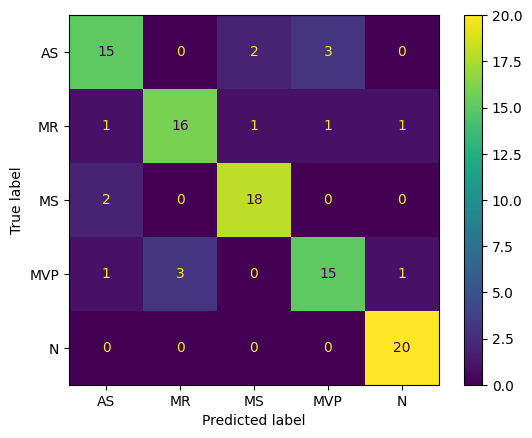

Accuracy : [0.91 0.93 0.95 0.91 0.98] mean:  0.9359999999999999
Precision : [0.78947368 0.84210526 0.85714286 0.78947368 0.90909091] mean:  0.8374572795625428
Sensitivity : [0.75 0.8  0.9  0.75 1.  ] mean:  0.8400000000000001
Specificity : [0.95   0.9625 0.9625 0.95   0.975 ] mean:  0.96
f1_score: [0.76923077 0.82051282 0.87804878 0.76923077 0.95238095] mean:  0.8378808183686232



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb6L5.csv_2.h5
4/4 [==============================] - 1s 8ms/step


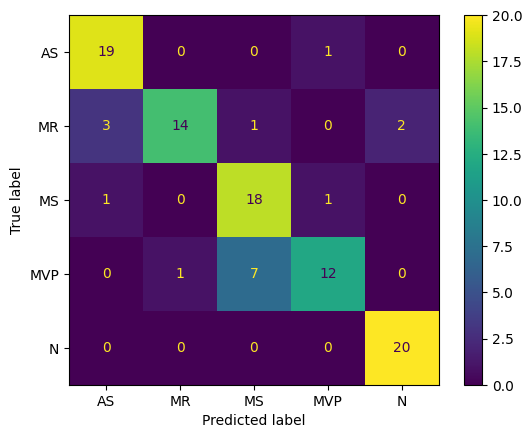

Accuracy : [0.95 0.93 0.9  0.9  0.98] mean:  0.932
Precision : [0.82608696 0.93333333 0.69230769 0.85714286 0.90909091] mean:  0.8435923496793061
Sensitivity : [0.95 0.7  0.9  0.6  1.  ] mean:  0.8300000000000001
Specificity : [0.95   0.9875 0.9    0.975  0.975 ] mean:  0.9574999999999999
f1_score: [0.88372093 0.8        0.7826087  0.70588235 0.95238095] mean:  0.8249185862413722



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb6L6.csv_2.h5
4/4 [==============================] - 0s 9ms/step


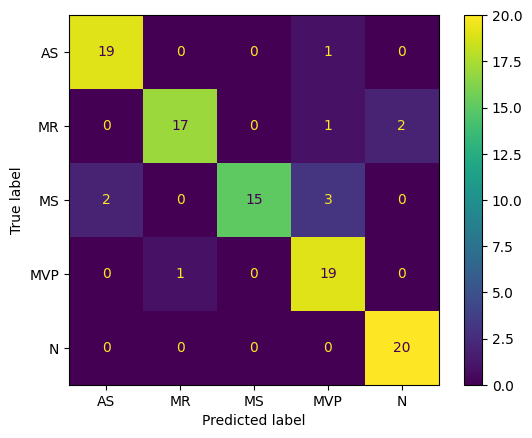

Accuracy : [0.97 0.96 0.95 0.94 0.98] mean:  0.96
Precision : [0.9047619  0.94444444 1.         0.79166667 0.90909091] mean:  0.909992784992785
Sensitivity : [0.95 0.85 0.75 0.95 1.  ] mean:  0.9
Specificity : [0.975  0.9875 1.     0.9375 0.975 ] mean:  0.975
f1_score: [0.92682927 0.89473684 0.85714286 0.86363636 0.95238095] mean:  0.8989452567116238



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb6L7.csv_2.h5
4/4 [==============================] - 0s 8ms/step


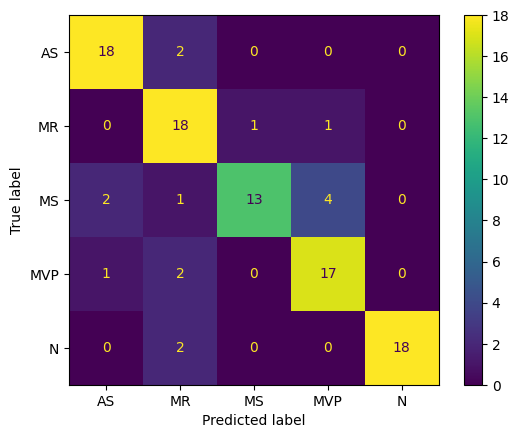

Accuracy : [0.95 0.91 0.92 0.92 0.98] mean:  0.9359999999999999
Precision : [0.85714286 0.72       0.92857143 0.77272727 1.        ] mean:  0.8556883116883116
Sensitivity : [0.9  0.9  0.65 0.85 0.9 ] mean:  0.8400000000000001
Specificity : [0.9625 0.9125 0.9875 0.9375 1.    ] mean:  0.96
f1_score: [0.87804878 0.8        0.76470588 0.80952381 0.94736842] mean:  0.8399293786834374



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb6L8.csv_3.h5
4/4 [==============================] - 0s 8ms/step


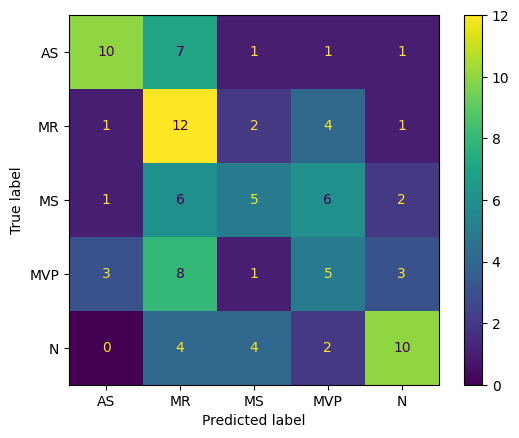

Accuracy : [0.85 0.67 0.77 0.72 0.83] mean:  0.768
Precision : [0.66666667 0.32432432 0.38461538 0.27777778 0.58823529] mean:  0.4483238895003601
Sensitivity : [0.5  0.6  0.25 0.25 0.5 ] mean:  0.42000000000000004
Specificity : [0.9375 0.6875 0.9    0.8375 0.9125] mean:  0.8549999999999999
f1_score: [0.57142857 0.42105263 0.3030303  0.26315789 0.54054054] mean:  0.4198419882630409



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb6L9.csv_3.h5
4/4 [==============================] - 0s 7ms/step


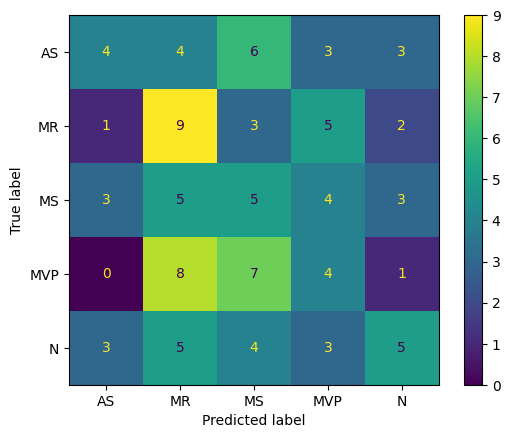

Accuracy : [0.77 0.67 0.65 0.69 0.76] mean:  0.708
Precision : [0.36363636 0.29032258 0.2        0.21052632 0.35714286] mean:  0.2843256234427712
Sensitivity : [0.2  0.45 0.25 0.2  0.25] mean:  0.27
Specificity : [0.9125 0.725  0.75   0.8125 0.8875] mean:  0.8175000000000001
f1_score: [0.25806452 0.35294118 0.22222222 0.20512821 0.29411765] mean:  0.26649475340177425



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb6L10.csv_4.h5
4/4 [==============================] - 0s 8ms/step


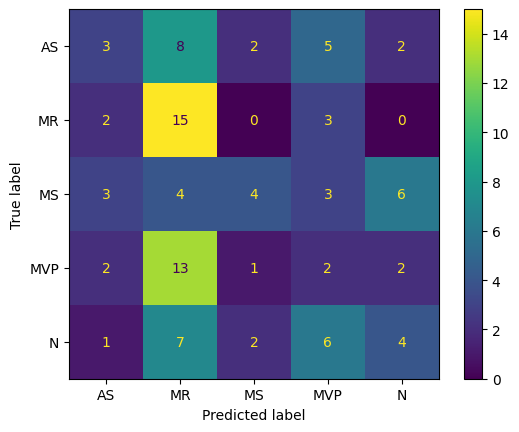

Accuracy : [0.75 0.63 0.79 0.65 0.74] mean:  0.712
Precision : [0.27272727 0.31914894 0.44444444 0.10526316 0.28571429] mean:  0.28545961939019043
Sensitivity : [0.15 0.75 0.2  0.1  0.2 ] mean:  0.28
Specificity : [0.9    0.6    0.9375 0.7875 0.875 ] mean:  0.82
f1_score: [0.19354839 0.44776119 0.27586207 0.1025641  0.23529412] mean:  0.2510059740606608



Accuracy All : [0.8360000000000001, 0.8720000000000001, 0.9120000000000001, 0.9359999999999999, 0.932, 0.96, 0.9359999999999999, 0.768, 0.708, 0.712]
Precision All : [0.5817362218678008, 0.6961391169740206, 0.780256121587391, 0.8374572795625428, 0.8435923496793061, 0.909992784992785, 0.8556883116883116, 0.4483238895003601, 0.2843256234427712, 0.28545961939019043]
Sensitivity All : [0.5900000000000001, 0.6799999999999999, 0.78, 0.8400000000000001, 0.8300000000000001, 0.9, 0.8400000000000001, 0.42000000000000004, 0.27, 0.28]
Specificity All : [0.8975, 0.9200000000000002, 0.945, 0.96, 0.9574999999999999, 0.975, 0.96, 0.8549999999999999,

In [18]:
testingVHD(a6, 6)

Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb7L1.csv_3.h5


4/4 [==============================] - 0s 8ms/step


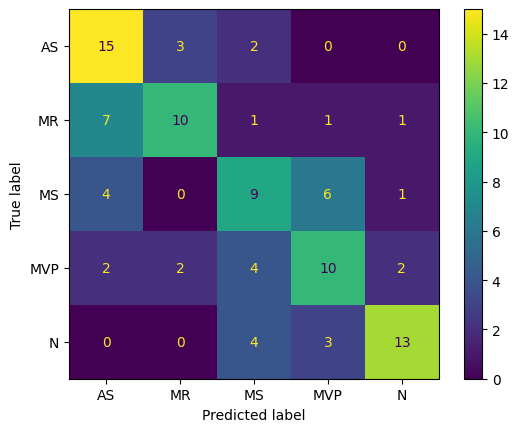

Accuracy : [0.82 0.85 0.78 0.8  0.89] mean:  0.828
Precision : [0.53571429 0.66666667 0.45       0.5        0.76470588] mean:  0.5834173669467787
Sensitivity : [0.75 0.5  0.45 0.5  0.65] mean:  0.5700000000000001
Specificity : [0.8375 0.9375 0.8625 0.875  0.95  ] mean:  0.8925000000000001
f1_score: [0.625      0.57142857 0.45       0.5        0.7027027 ] mean:  0.5698262548262548



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb7L2.csv_3.h5
4/4 [==============================] - 0s 8ms/step


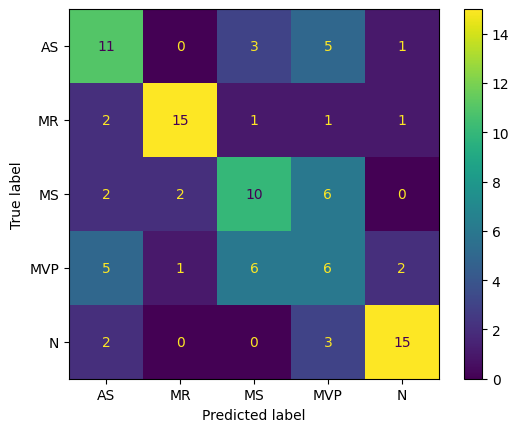

Accuracy : [0.8  0.92 0.8  0.71 0.91] mean:  0.8280000000000001
Precision : [0.5        0.83333333 0.5        0.28571429 0.78947368] mean:  0.5817042606516291
Sensitivity : [0.55 0.75 0.5  0.3  0.75] mean:  0.5700000000000001
Specificity : [0.8625 0.9625 0.875  0.8125 0.95  ] mean:  0.8925000000000001
f1_score: [0.52380952 0.78947368 0.5        0.29268293 0.76923077] mean:  0.5750393808160175



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb7L3.csv_2.h5
4/4 [==============================] - 0s 8ms/step


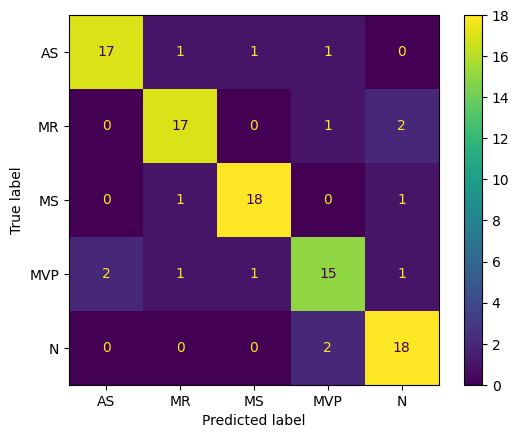

Accuracy : [0.95 0.94 0.96 0.91 0.94] mean:  0.9399999999999998
Precision : [0.89473684 0.85       0.9        0.78947368 0.81818182] mean:  0.8504784688995215
Sensitivity : [0.85 0.85 0.9  0.75 0.9 ] mean:  0.85
Specificity : [0.975  0.9625 0.975  0.95   0.95  ] mean:  0.9625
f1_score: [0.87179487 0.85       0.9        0.76923077 0.85714286] mean:  0.8496336996336996



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb7L4.csv_2.h5
4/4 [==============================] - 1s 9ms/step


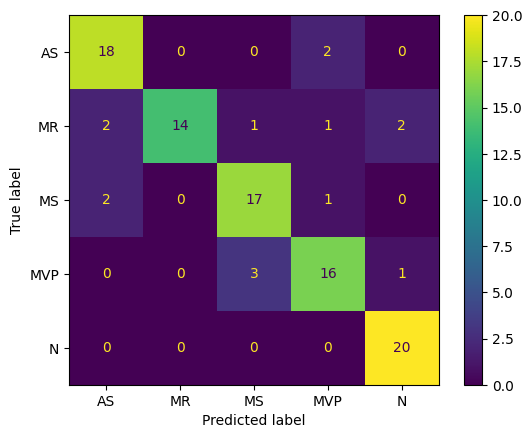

Accuracy : [0.94 0.94 0.93 0.92 0.97] mean:  0.9400000000000001
Precision : [0.81818182 1.         0.80952381 0.8        0.86956522] mean:  0.8594541690193864
Sensitivity : [0.9  0.7  0.85 0.8  1.  ] mean:  0.85
Specificity : [0.95   1.     0.95   0.95   0.9625] mean:  0.9625
f1_score: [0.85714286 0.82352941 0.82926829 0.8        0.93023256] mean:  0.848034623946005



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb7L5.csv_5.h5
4/4 [==============================] - 0s 8ms/step


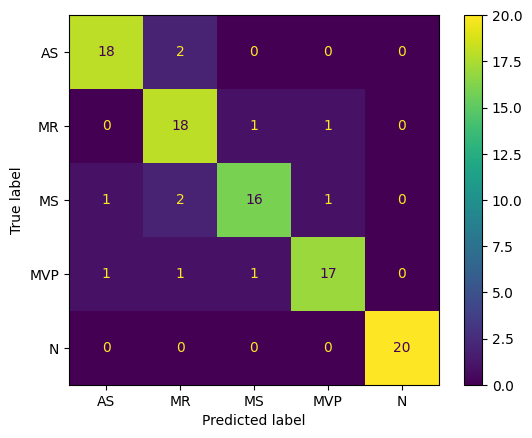

Accuracy : [0.96 0.93 0.94 0.95 1.  ] mean:  0.9560000000000001
Precision : [0.9        0.7826087  0.88888889 0.89473684 1.        ] mean:  0.8932468853292651
Sensitivity : [0.9  0.9  0.8  0.85 1.  ] mean:  0.89
Specificity : [0.975  0.9375 0.975  0.975  1.    ] mean:  0.9725000000000001
f1_score: [0.9        0.8372093  0.84210526 0.87179487 1.        ] mean:  0.8902218874556695



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb7L6.csv_2.h5
4/4 [==============================] - 0s 9ms/step


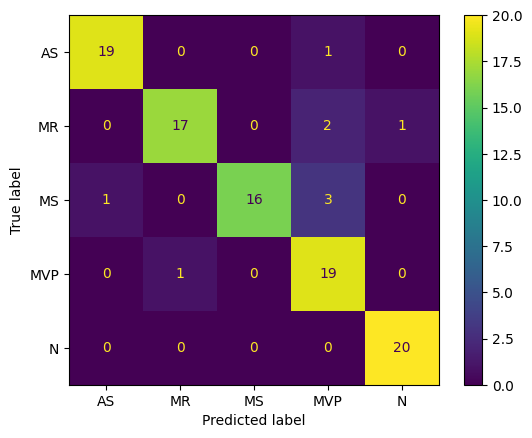

Accuracy : [0.98 0.96 0.96 0.93 0.99] mean:  0.9640000000000001
Precision : [0.95       0.94444444 1.         0.76       0.95238095] mean:  0.9213650793650794
Sensitivity : [0.95 0.85 0.8  0.95 1.  ] mean:  0.9099999999999999
Specificity : [0.9875 0.9875 1.     0.925  0.9875] mean:  0.9775
f1_score: [0.95       0.89473684 0.88888889 0.84444444 0.97560976] mean:  0.9107359863072315



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb7L7.csv_2.h5
4/4 [==============================] - 0s 9ms/step


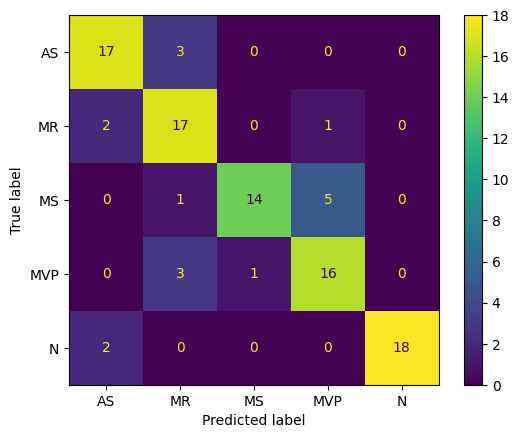

Accuracy : [0.93 0.9  0.93 0.9  0.98] mean:  0.9280000000000002
Precision : [0.80952381 0.70833333 0.93333333 0.72727273 1.        ] mean:  0.8356926406926407
Sensitivity : [0.85 0.85 0.7  0.8  0.9 ] mean:  0.8200000000000001
Specificity : [0.95   0.9125 0.9875 0.925  1.    ] mean:  0.9549999999999998
f1_score: [0.82926829 0.77272727 0.8        0.76190476 0.94736842] mean:  0.8222537496735187



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb7L8.csv_4.h5
4/4 [==============================] - 0s 8ms/step


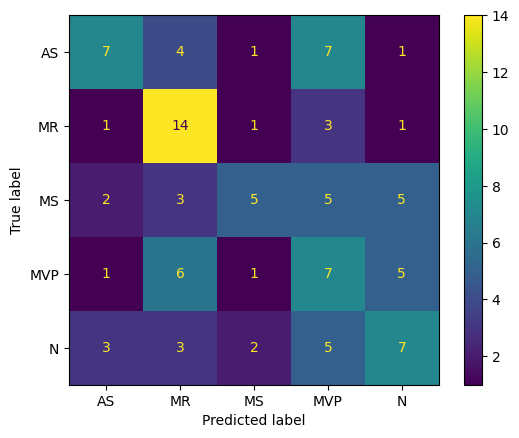

Accuracy : [0.8  0.78 0.8  0.67 0.75] mean:  0.76
Precision : [0.5        0.46666667 0.5        0.25925926 0.36842105] mean:  0.418869395711501
Sensitivity : [0.35 0.7  0.25 0.35 0.35] mean:  0.4
Specificity : [0.9125 0.8    0.9375 0.75   0.85  ] mean:  0.85
f1_score: [0.41176471 0.56       0.33333333 0.29787234 0.35897436] mean:  0.39238894772311544



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb7L9.csv_4.h5
4/4 [==============================] - 0s 8ms/step


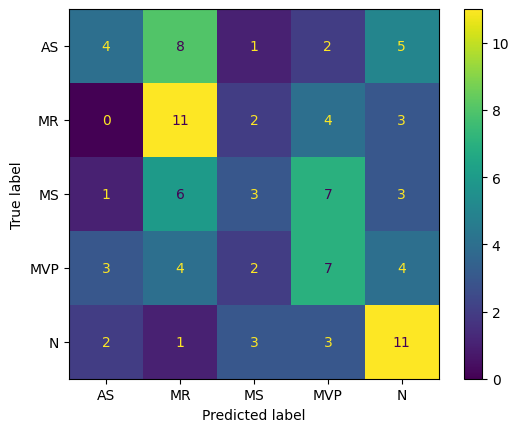

Accuracy : [0.78 0.72 0.75 0.71 0.76] mean:  0.744
Precision : [0.4        0.36666667 0.27272727 0.30434783 0.42307692] mean:  0.3533637377115638
Sensitivity : [0.2  0.55 0.15 0.35 0.55] mean:  0.36
Specificity : [0.925  0.7625 0.9    0.8    0.8125] mean:  0.8400000000000001
f1_score: [0.26666667 0.44       0.19354839 0.3255814  0.47826087] mean:  0.34081146373549903



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb7L10.csv_2.h5
4/4 [==============================] - 0s 8ms/step


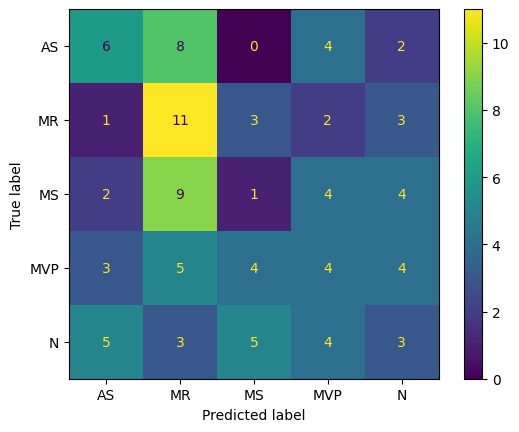

Accuracy : [0.75 0.66 0.69 0.7  0.7 ] mean:  0.7
Precision : [0.35294118 0.30555556 0.07692308 0.22222222 0.1875    ] mean:  0.2290284062342886
Sensitivity : [0.3  0.55 0.05 0.2  0.15] mean:  0.25
Specificity : [0.8625 0.6875 0.85   0.825  0.8375] mean:  0.8125
f1_score: [0.32432432 0.39285714 0.06060606 0.21052632 0.16666667] mean:  0.2309961020487336



Accuracy All : [0.828, 0.8280000000000001, 0.9399999999999998, 0.9400000000000001, 0.9560000000000001, 0.9640000000000001, 0.9280000000000002, 0.76, 0.744, 0.7]
Precision All : [0.5834173669467787, 0.5817042606516291, 0.8504784688995215, 0.8594541690193864, 0.8932468853292651, 0.9213650793650794, 0.8356926406926407, 0.418869395711501, 0.3533637377115638, 0.2290284062342886]
Sensitivity All : [0.5700000000000001, 0.5700000000000001, 0.85, 0.85, 0.89, 0.9099999999999999, 0.8200000000000001, 0.4, 0.36, 0.25]
Specificity All : [0.8925000000000001, 0.8925000000000001, 0.9625, 0.9625, 0.9725000000000001, 0.9775, 0.9549999999999998, 0.85, 0.

In [19]:
testingVHD(a7, 7)

Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb8L1.csv_5.h5


4/4 [==============================] - 0s 8ms/step


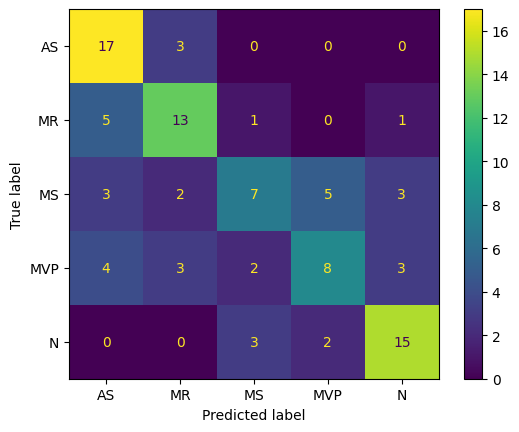

Accuracy : [0.85 0.85 0.81 0.81 0.88] mean:  0.8400000000000001
Precision : [0.5862069  0.61904762 0.53846154 0.53333333 0.68181818] mean:  0.5917735138424793
Sensitivity : [0.85 0.65 0.35 0.4  0.75] mean:  0.6
Specificity : [0.85   0.9    0.925  0.9125 0.9125] mean:  0.9
f1_score: [0.69387755 0.63414634 0.42424242 0.45714286 0.71428571] mean:  0.5847389776309637



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb8L2.csv_5.h5
4/4 [==============================] - 0s 9ms/step


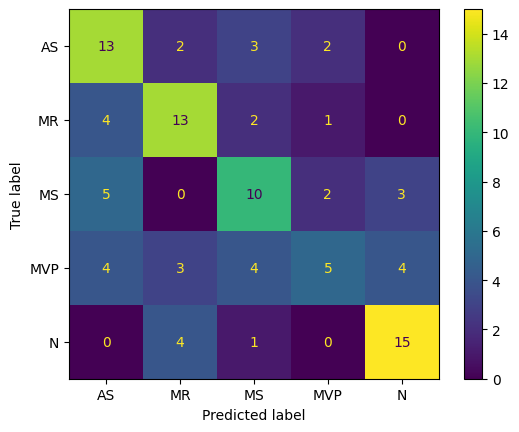

Accuracy : [0.8  0.84 0.8  0.8  0.88] mean:  0.8240000000000001
Precision : [0.5        0.59090909 0.5        0.5        0.68181818] mean:  0.5545454545454545
Sensitivity : [0.65 0.65 0.5  0.25 0.75] mean:  0.5599999999999999
Specificity : [0.8375 0.8875 0.875  0.9375 0.9125] mean:  0.89
f1_score: [0.56521739 0.61904762 0.5        0.33333333 0.71428571] mean:  0.5463768115942029



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb8L3.csv_2.h5
4/4 [==============================] - 0s 10ms/step


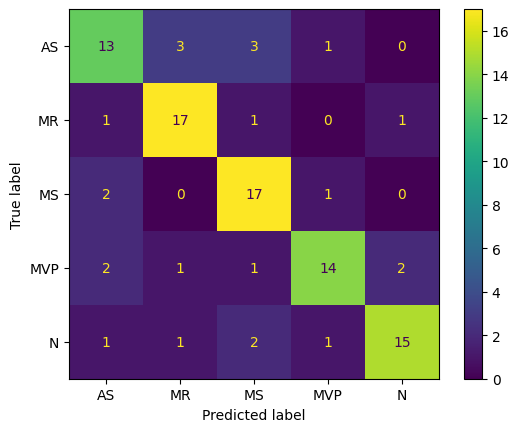

Accuracy : [0.87 0.92 0.9  0.91 0.92] mean:  0.9040000000000001
Precision : [0.68421053 0.77272727 0.70833333 0.82352941 0.83333333] mean:  0.764426775494887
Sensitivity : [0.65 0.85 0.85 0.7  0.75] mean:  0.76
Specificity : [0.925  0.9375 0.9125 0.9625 0.9625] mean:  0.9400000000000001
f1_score: [0.66666667 0.80952381 0.77272727 0.75675676 0.78947368] mean:  0.7590296379770063



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb8L4.csv_5.h5
4/4 [==============================] - 0s 8ms/step


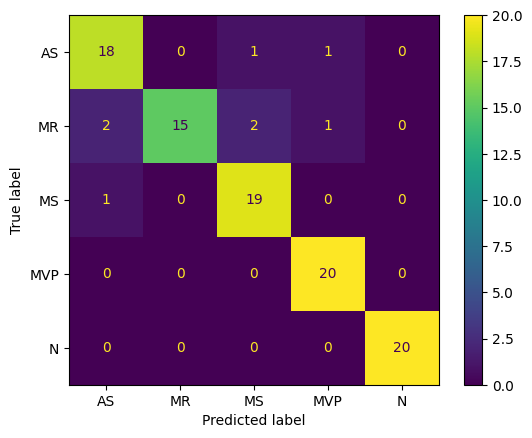

Accuracy : [0.95 0.95 0.96 0.98 1.  ] mean:  0.968
Precision : [0.85714286 1.         0.86363636 0.90909091 1.        ] mean:  0.925974025974026
Sensitivity : [0.9  0.75 0.95 1.   1.  ] mean:  0.9199999999999999
Specificity : [0.9625 1.     0.9625 0.975  1.    ] mean:  0.9800000000000001
f1_score: [0.87804878 0.85714286 0.9047619  0.95238095 1.        ] mean:  0.9184668989547038



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb8L5.csv_2.h5
4/4 [==============================] - 0s 9ms/step


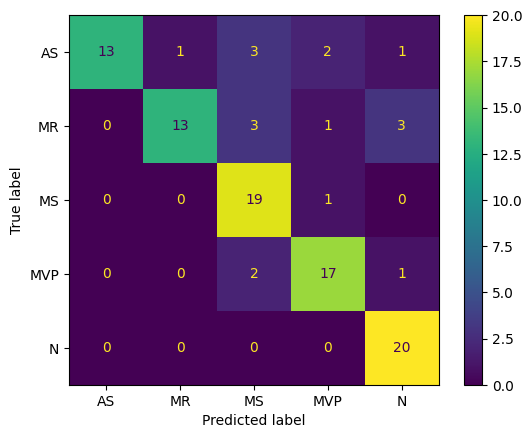

Accuracy : [0.93 0.92 0.91 0.93 0.95] mean:  0.9280000000000002
Precision : [1.         0.92857143 0.7037037  0.80952381 0.8       ] mean:  0.8483597883597882
Sensitivity : [0.65 0.65 0.95 0.85 1.  ] mean:  0.82
Specificity : [1.     0.9875 0.9    0.95   0.9375] mean:  0.9550000000000001
f1_score: [0.78787879 0.76470588 0.80851064 0.82926829 0.88888889] mean:  0.8158504980202835



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb8L6.csv_2.h5
4/4 [==============================] - 0s 8ms/step


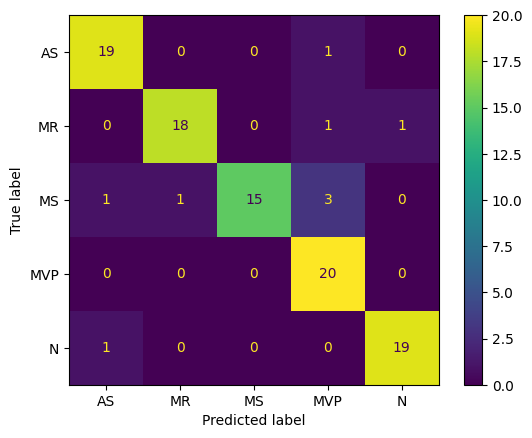

Accuracy : [0.97 0.97 0.95 0.95 0.98] mean:  0.9640000000000001
Precision : [0.9047619  0.94736842 1.         0.8        0.95      ] mean:  0.9204260651629073
Sensitivity : [0.95 0.9  0.75 1.   0.95] mean:  0.9099999999999999
Specificity : [0.975  0.9875 1.     0.9375 0.9875] mean:  0.9775
f1_score: [0.92682927 0.92307692 0.85714286 0.88888889 0.95      ] mean:  0.9091875874802703



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb8L7.csv_5.h5
4/4 [==============================] - 0s 9ms/step


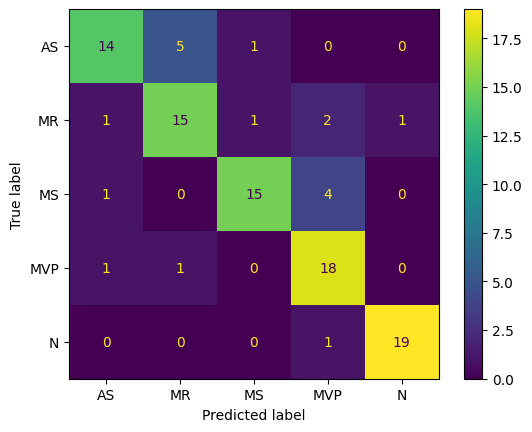

Accuracy : [0.91 0.89 0.93 0.91 0.98] mean:  0.924
Precision : [0.82352941 0.71428571 0.88235294 0.72       0.95      ] mean:  0.8180336134453782
Sensitivity : [0.7  0.75 0.75 0.9  0.95] mean:  0.8099999999999999
Specificity : [0.9625 0.925  0.975  0.9125 0.9875] mean:  0.9525
f1_score: [0.75675676 0.73170732 0.81081081 0.8        0.95      ] mean:  0.8098549769281476



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb8L8.csv_3.h5
4/4 [==============================] - 0s 9ms/step


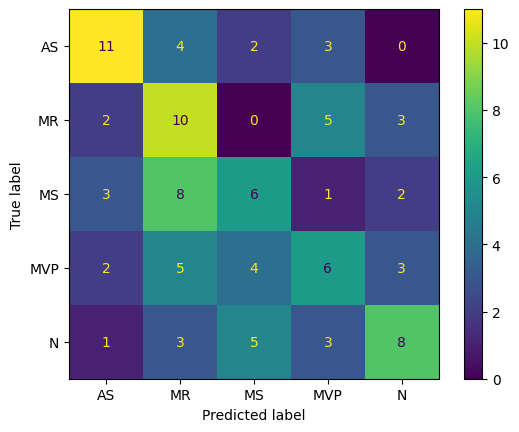

Accuracy : [0.83 0.7  0.75 0.74 0.8 ] mean:  0.7639999999999999
Precision : [0.57894737 0.33333333 0.35294118 0.33333333 0.5       ] mean:  0.4197110423116615
Sensitivity : [0.55 0.5  0.3  0.3  0.4 ] mean:  0.41000000000000003
Specificity : [0.9    0.75   0.8625 0.85   0.9   ] mean:  0.8525
f1_score: [0.56410256 0.4        0.32432432 0.31578947 0.44444444] mean:  0.40973216131110873



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb8L9.csv_2.h5
4/4 [==============================] - 0s 8ms/step


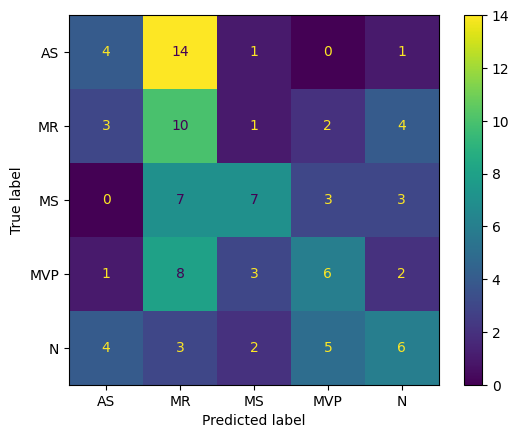

Accuracy : [0.76 0.58 0.8  0.76 0.76] mean:  0.7319999999999999
Precision : [0.33333333 0.23809524 0.5        0.375      0.375     ] mean:  0.36428571428571427
Sensitivity : [0.2  0.5  0.35 0.3  0.3 ] mean:  0.32999999999999996
Specificity : [0.9    0.6    0.9125 0.875  0.875 ] mean:  0.8324999999999999
f1_score: [0.25       0.32258065 0.41176471 0.33333333 0.33333333] mean:  0.33020240354206193



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb8L10.csv_5.h5
4/4 [==============================] - 0s 8ms/step


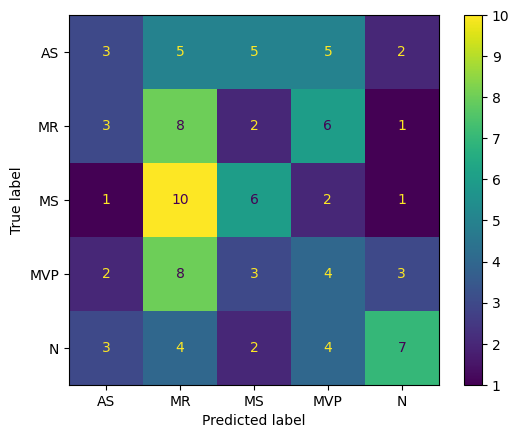

Accuracy : [0.74 0.61 0.74 0.67 0.8 ] mean:  0.712
Precision : [0.25       0.22857143 0.33333333 0.19047619 0.5       ] mean:  0.30047619047619045
Sensitivity : [0.15 0.4  0.3  0.2  0.35] mean:  0.27999999999999997
Specificity : [0.8875 0.6625 0.85   0.7875 0.9125] mean:  0.82
f1_score: [0.1875     0.29090909 0.31578947 0.19512195 0.41176471] mean:  0.28021704433903327



Accuracy All : [0.8400000000000001, 0.8240000000000001, 0.9040000000000001, 0.968, 0.9280000000000002, 0.9640000000000001, 0.924, 0.7639999999999999, 0.7319999999999999, 0.712]
Precision All : [0.5917735138424793, 0.5545454545454545, 0.764426775494887, 0.925974025974026, 0.8483597883597882, 0.9204260651629073, 0.8180336134453782, 0.4197110423116615, 0.36428571428571427, 0.30047619047619045]
Sensitivity All : [0.6, 0.5599999999999999, 0.76, 0.9199999999999999, 0.82, 0.9099999999999999, 0.8099999999999999, 0.41000000000000003, 0.32999999999999996, 0.27999999999999997]
Specificity All : [0.9, 0.89, 0.9400000000000001, 0.

In [20]:
testingVHD(a8, 8)

Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb9L1.csv_5.h5


4/4 [==============================] - 0s 8ms/step


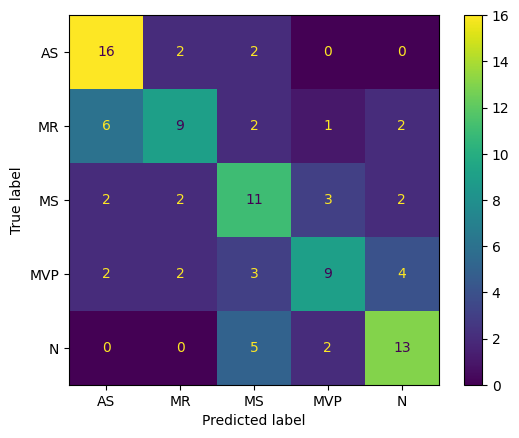

Accuracy : [0.86 0.83 0.79 0.83 0.85] mean:  0.8320000000000001
Precision : [0.61538462 0.6        0.47826087 0.6        0.61904762] mean:  0.5825386207994904
Sensitivity : [0.8  0.45 0.55 0.45 0.65] mean:  0.58
Specificity : [0.875 0.925 0.85  0.925 0.9  ] mean:  0.8950000000000001
f1_score: [0.69565217 0.51428571 0.51162791 0.51428571 0.63414634] mean:  0.5739995701849262



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb9L2.csv_5.h5
4/4 [==============================] - 0s 8ms/step


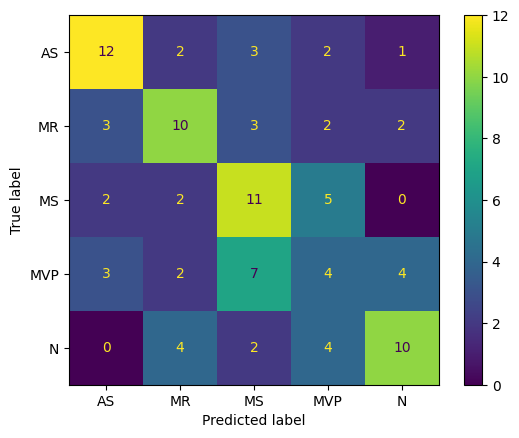

Accuracy : [0.84 0.8  0.76 0.71 0.83] mean:  0.788
Precision : [0.6        0.5        0.42307692 0.23529412 0.58823529] mean:  0.4693212669683258
Sensitivity : [0.6  0.5  0.55 0.2  0.5 ] mean:  0.47000000000000003
Specificity : [0.9    0.875  0.8125 0.8375 0.9125] mean:  0.8674999999999999
f1_score: [0.6        0.5        0.47826087 0.21621622 0.54054054] mean:  0.4670035252643948



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb9L3.csv_5.h5
4/4 [==============================] - 0s 9ms/step


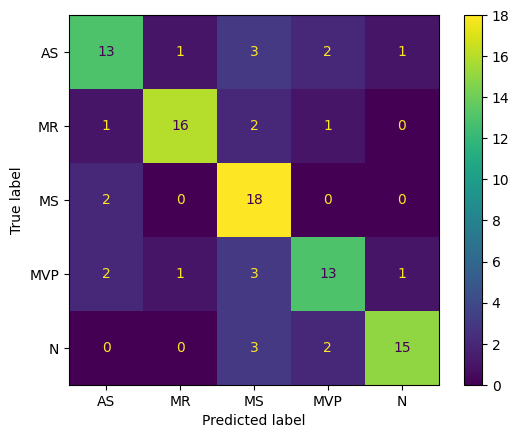

Accuracy : [0.88 0.94 0.87 0.88 0.93] mean:  0.9
Precision : [0.72222222 0.88888889 0.62068966 0.72222222 0.88235294] mean:  0.7672751859364435
Sensitivity : [0.65 0.8  0.9  0.65 0.75] mean:  0.75
Specificity : [0.9375 0.975  0.8625 0.9375 0.975 ] mean:  0.9375
f1_score: [0.68421053 0.84210526 0.73469388 0.68421053 0.81081081] mean:  0.751206200830261



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb9L4.csv_2.h5
4/4 [==============================] - 0s 9ms/step


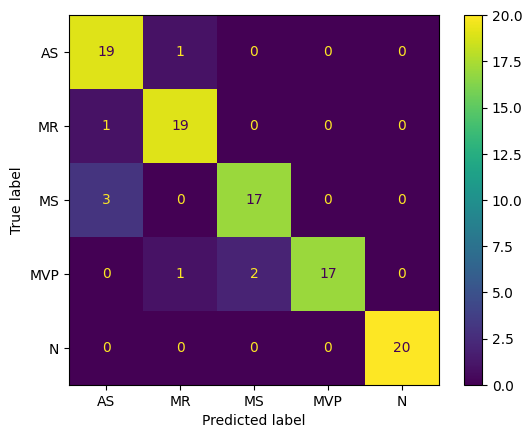

Accuracy : [0.95 0.97 0.95 0.97 1.  ] mean:  0.968
Precision : [0.82608696 0.9047619  0.89473684 1.         1.        ] mean:  0.9251171406777814
Sensitivity : [0.95 0.95 0.85 0.85 1.  ] mean:  0.9199999999999999
Specificity : [0.95  0.975 0.975 1.    1.   ] mean:  0.9800000000000001
f1_score: [0.88372093 0.92682927 0.87179487 0.91891892 1.        ] mean:  0.9202527978478063



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb9L5.csv_2.h5
4/4 [==============================] - 0s 8ms/step


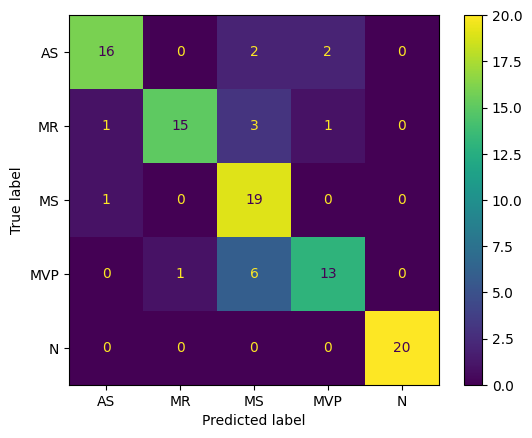

Accuracy : [0.94 0.94 0.88 0.9  1.  ] mean:  0.932
Precision : [0.88888889 0.9375     0.63333333 0.8125     1.        ] mean:  0.8544444444444445
Sensitivity : [0.8  0.75 0.95 0.65 1.  ] mean:  0.8300000000000001
Specificity : [0.975  0.9875 0.8625 0.9625 1.    ] mean:  0.9574999999999999
f1_score: [0.84210526 0.83333333 0.76       0.72222222 1.        ] mean:  0.8315321637426901



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb9L6.csv_2.h5
4/4 [==============================] - 0s 8ms/step


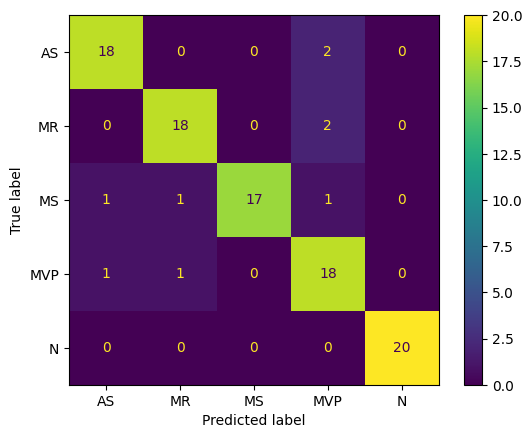

Accuracy : [0.96 0.96 0.97 0.93 1.  ] mean:  0.9640000000000001
Precision : [0.9       0.9       1.        0.7826087 1.       ] mean:  0.9165217391304348
Sensitivity : [0.9  0.9  0.85 0.9  1.  ] mean:  0.9099999999999999
Specificity : [0.975  0.975  1.     0.9375 1.    ] mean:  0.9775
f1_score: [0.9        0.9        0.91891892 0.8372093  1.        ] mean:  0.9112256442489002



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb9L7.csv_5.h5
4/4 [==============================] - 0s 9ms/step


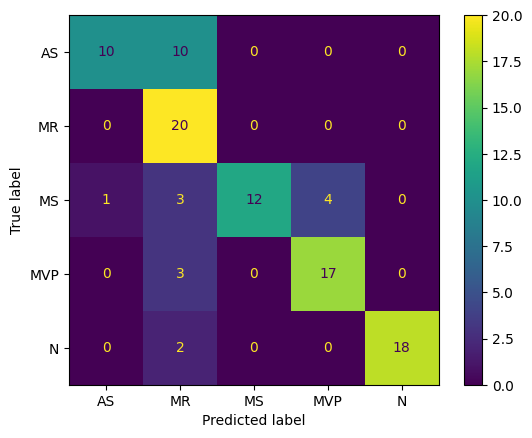

Accuracy : [0.89 0.82 0.92 0.93 0.98] mean:  0.908
Precision : [0.90909091 0.52631579 1.         0.80952381 1.        ] mean:  0.8489861016176805
Sensitivity : [0.5  1.   0.6  0.85 0.9 ] mean:  0.77
Specificity : [0.9875 0.775  1.     0.95   1.    ] mean:  0.9425000000000001
f1_score: [0.64516129 0.68965517 0.75       0.82926829 0.94736842] mean:  0.7722906352943865



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb9L8.csv_1.h5
4/4 [==============================] - 0s 10ms/step


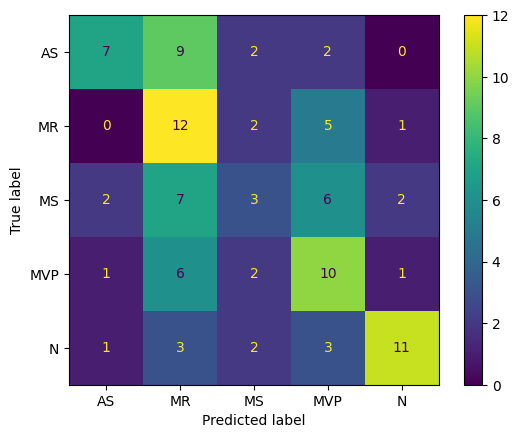

Accuracy : [0.83 0.67 0.75 0.74 0.87] mean:  0.772
Precision : [0.63636364 0.32432432 0.27272727 0.38461538 0.73333333] mean:  0.47027279027279023
Sensitivity : [0.35 0.6  0.15 0.5  0.55] mean:  0.43
Specificity : [0.95   0.6875 0.9    0.8    0.95  ] mean:  0.8575000000000002
f1_score: [0.4516129  0.42105263 0.19354839 0.43478261 0.62857143] mean:  0.42591359183372174



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb9L9.csv_5.h5
4/4 [==============================] - 0s 9ms/step


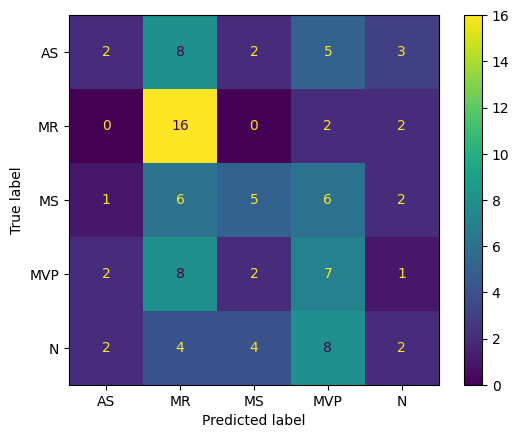

Accuracy : [0.77 0.7  0.77 0.66 0.74] mean:  0.7280000000000001
Precision : [0.28571429 0.38095238 0.38461538 0.25       0.2       ] mean:  0.30025641025641026
Sensitivity : [0.1  0.8  0.25 0.35 0.1 ] mean:  0.32
Specificity : [0.9375 0.675  0.9    0.7375 0.9   ] mean:  0.8300000000000001
f1_score: [0.14814815 0.51612903 0.3030303  0.29166667 0.13333333] mean:  0.27846149668730313



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb9L10.csv_4.h5
4/4 [==============================] - 0s 7ms/step


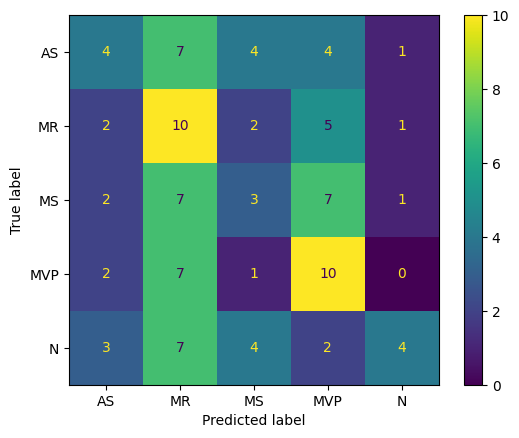

Accuracy : [0.75 0.62 0.72 0.72 0.81] mean:  0.724
Precision : [0.30769231 0.26315789 0.21428571 0.35714286 0.57142857] mean:  0.3427414690572585
Sensitivity : [0.2  0.5  0.15 0.5  0.2 ] mean:  0.31
Specificity : [0.8875 0.65   0.8625 0.775  0.9625] mean:  0.8275
f1_score: [0.24242424 0.34482759 0.17647059 0.41666667 0.2962963 ] mean:  0.2953370759658792



Accuracy All : [0.8320000000000001, 0.788, 0.9, 0.968, 0.932, 0.9640000000000001, 0.908, 0.772, 0.7280000000000001, 0.724]
Precision All : [0.5825386207994904, 0.4693212669683258, 0.7672751859364435, 0.9251171406777814, 0.8544444444444445, 0.9165217391304348, 0.8489861016176805, 0.47027279027279023, 0.30025641025641026, 0.3427414690572585]
Sensitivity All : [0.58, 0.47000000000000003, 0.75, 0.9199999999999999, 0.8300000000000001, 0.9099999999999999, 0.77, 0.43, 0.32, 0.31]
Specificity All : [0.8950000000000001, 0.8674999999999999, 0.9375, 0.9800000000000001, 0.9574999999999999, 0.9775, 0.9425000000000001, 0.8575000000000002, 0.83000

In [21]:
testingVHD(a9, 9)

Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb10L1.csv_2.h5
4/4 [==============================] - 0s 8ms/step


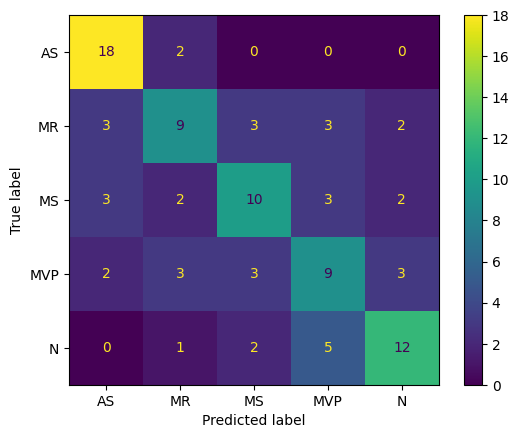

Accuracy : [0.9  0.81 0.82 0.78 0.85] mean:  0.8319999999999999
Precision : [0.69230769 0.52941176 0.55555556 0.45       0.63157895] mean:  0.5717707919875104
Sensitivity : [0.9  0.45 0.5  0.45 0.6 ] mean:  0.5800000000000001
Specificity : [0.9    0.9    0.9    0.8625 0.9125] mean:  0.8949999999999999
f1_score: [0.7826087  0.48648649 0.52631579 0.45       0.61538462] mean:  0.572159117399392



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb10L2.csv_3.h5
4/4 [==============================] - 0s 8ms/step


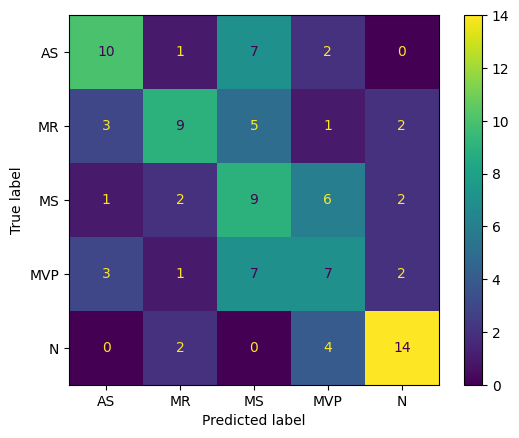

Accuracy : [0.83 0.83 0.7  0.74 0.88] mean:  0.7959999999999999
Precision : [0.58823529 0.6        0.32142857 0.35       0.7       ] mean:  0.5119327731092437
Sensitivity : [0.5  0.45 0.45 0.35 0.7 ] mean:  0.49000000000000005
Specificity : [0.9125 0.925  0.7625 0.8375 0.925 ] mean:  0.8724999999999999
f1_score: [0.54054054 0.51428571 0.375      0.35       0.7       ] mean:  0.4959652509652509



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb10L3.csv_3.h5
4/4 [==============================] - 0s 8ms/step


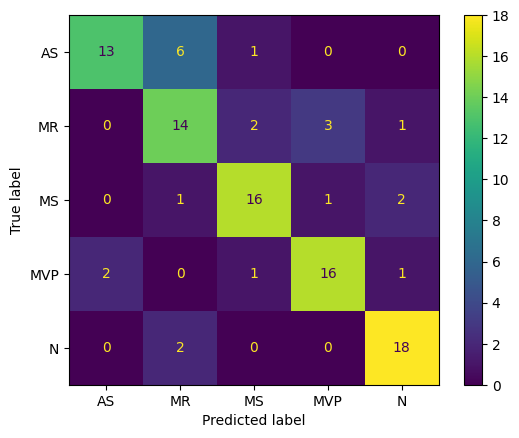

Accuracy : [0.91 0.85 0.92 0.92 0.94] mean:  0.908
Precision : [0.86666667 0.60869565 0.8        0.8        0.81818182] mean:  0.7787088274044797
Sensitivity : [0.65 0.7  0.8  0.8  0.9 ] mean:  0.77
Specificity : [0.975  0.8875 0.95   0.95   0.95  ] mean:  0.9425000000000001
f1_score: [0.74285714 0.65116279 0.8        0.8        0.85714286] mean:  0.770232558139535



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb10L4.csv_2.h5
4/4 [==============================] - 0s 8ms/step


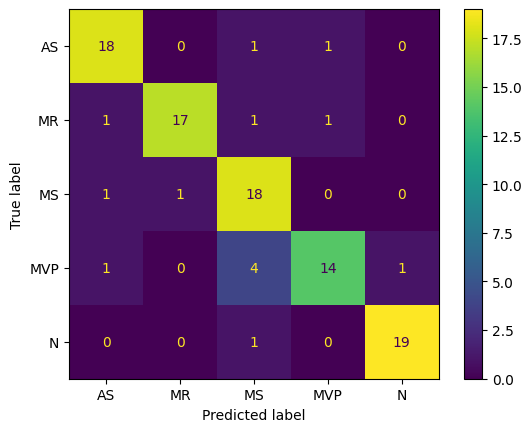

Accuracy : [0.95 0.96 0.91 0.92 0.98] mean:  0.944
Precision : [0.85714286 0.94444444 0.72       0.875      0.95      ] mean:  0.8693174603174603
Sensitivity : [0.9  0.85 0.9  0.7  0.95] mean:  0.86
Specificity : [0.9625 0.9875 0.9125 0.975  0.9875] mean:  0.9650000000000001
f1_score: [0.87804878 0.89473684 0.8        0.77777778 0.95      ] mean:  0.8601126800741691



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb10L5.csv_5.h5
4/4 [==============================] - 0s 8ms/step


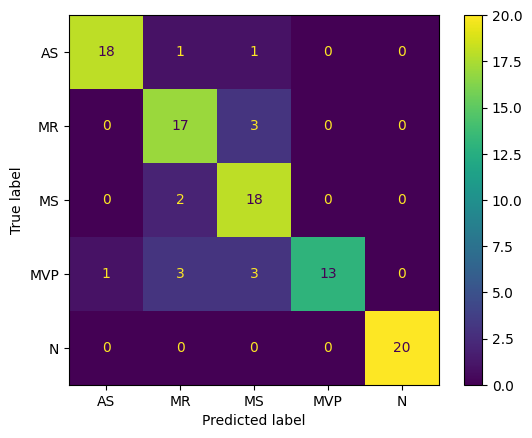

Accuracy : [0.97 0.91 0.91 0.93 1.  ] mean:  0.9440000000000002
Precision : [0.94736842 0.73913043 0.72       1.         1.        ] mean:  0.881299771167048
Sensitivity : [0.9  0.85 0.9  0.65 1.  ] mean:  0.86
Specificity : [0.9875 0.925  0.9125 1.     1.    ] mean:  0.9650000000000001
f1_score: [0.92307692 0.79069767 0.8        0.78787879 1.        ] mean:  0.8603306770748631



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb10L6.csv_2.h5
4/4 [==============================] - 0s 8ms/step


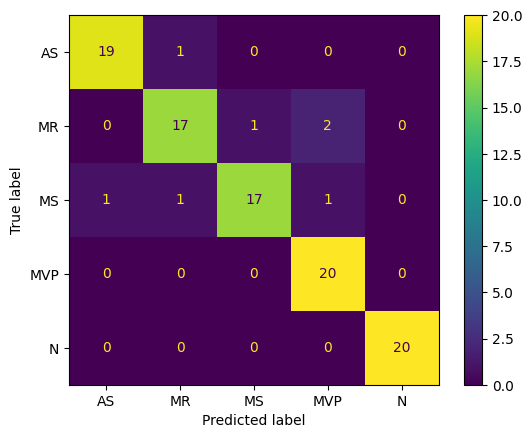

Accuracy : [0.98 0.95 0.96 0.97 1.  ] mean:  0.9719999999999999
Precision : [0.95       0.89473684 0.94444444 0.86956522 1.        ] mean:  0.9317493007882025
Sensitivity : [0.95 0.85 0.85 1.   1.  ] mean:  0.93
Specificity : [0.9875 0.975  0.9875 0.9625 1.    ] mean:  0.9824999999999999
f1_score: [0.95       0.87179487 0.89473684 0.93023256 1.        ] mean:  0.929352854407934



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb10L7.csv_4.h5
4/4 [==============================] - 0s 9ms/step


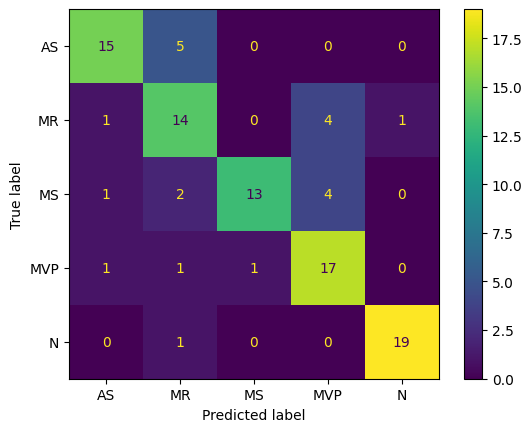

Accuracy : [0.92 0.85 0.92 0.89 0.98] mean:  0.9120000000000001
Precision : [0.83333333 0.60869565 0.92857143 0.68       0.95      ] mean:  0.800120082815735
Sensitivity : [0.75 0.7  0.65 0.85 0.95] mean:  0.78
Specificity : [0.9625 0.8875 0.9875 0.9    0.9875] mean:  0.9450000000000001
f1_score: [0.78947368 0.65116279 0.76470588 0.75555556 0.95      ] mean:  0.7821795825633395



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb10L8.csv_2.h5
4/4 [==============================] - 0s 8ms/step


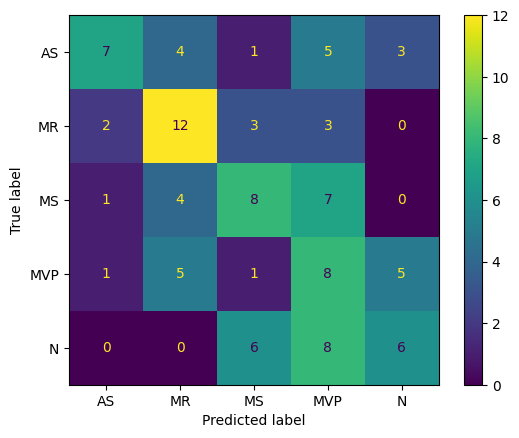

Accuracy : [0.83 0.79 0.77 0.65 0.78] mean:  0.764
Precision : [0.63636364 0.48       0.42105263 0.25806452 0.42857143] mean:  0.4448104425286089
Sensitivity : [0.35 0.6  0.4  0.4  0.3 ] mean:  0.41
Specificity : [0.95   0.8375 0.8625 0.7125 0.9   ] mean:  0.8525
f1_score: [0.4516129  0.53333333 0.41025641 0.31372549 0.35294118] mean:  0.41237386269644327



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb10L9.csv_2.h5
4/4 [==============================] - 0s 9ms/step


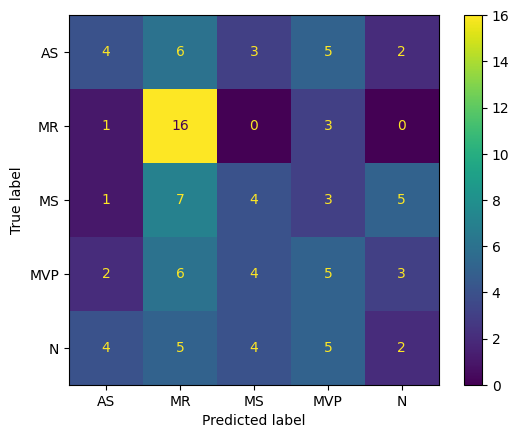

Accuracy : [0.76 0.72 0.73 0.69 0.72] mean:  0.724
Precision : [0.33333333 0.4        0.26666667 0.23809524 0.16666667] mean:  0.28095238095238095
Sensitivity : [0.2  0.8  0.2  0.25 0.1 ] mean:  0.31
Specificity : [0.9    0.7    0.8625 0.8    0.875 ] mean:  0.8275
f1_score: [0.25       0.53333333 0.22857143 0.24390244 0.125     ] mean:  0.27616144018583044



Processing ../modelh5/LSTM_NT/best_model/LSTM_NT_KFold_data_MfccDwtChromaCqtdb10L10.csv_3.h5
4/4 [==============================] - 0s 8ms/step


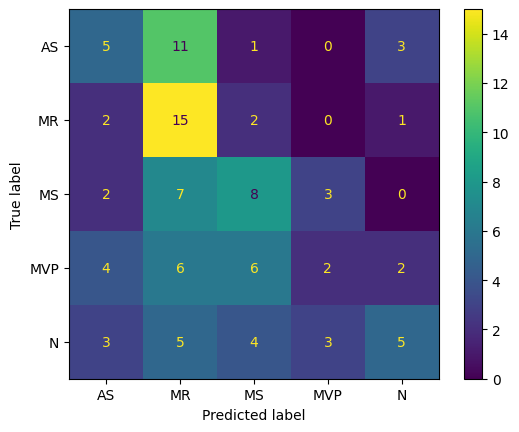

Accuracy : [0.74 0.66 0.75 0.76 0.79] mean:  0.74
Precision : [0.3125     0.34090909 0.38095238 0.25       0.45454545] mean:  0.34778138528138525
Sensitivity : [0.25 0.75 0.4  0.1  0.25] mean:  0.35
Specificity : [0.8625 0.6375 0.8375 0.925  0.925 ] mean:  0.8375
f1_score: [0.27777778 0.46875    0.3902439  0.14285714 0.32258065] mean:  0.32044189364704706



Accuracy All : [0.8319999999999999, 0.7959999999999999, 0.908, 0.944, 0.9440000000000002, 0.9719999999999999, 0.9120000000000001, 0.764, 0.724, 0.74]
Precision All : [0.5717707919875104, 0.5119327731092437, 0.7787088274044797, 0.8693174603174603, 0.881299771167048, 0.9317493007882025, 0.800120082815735, 0.4448104425286089, 0.28095238095238095, 0.34778138528138525]
Sensitivity All : [0.5800000000000001, 0.49000000000000005, 0.77, 0.86, 0.86, 0.93, 0.78, 0.41, 0.31, 0.35]
Specificity All : [0.8949999999999999, 0.8724999999999999, 0.9425000000000001, 0.9650000000000001, 0.9650000000000001, 0.9824999999999999, 0.9450000000000001, 0.852

In [22]:
testingVHD(a10, 10)